In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
import stretched_echelle_widget as sew
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib notebook

# import stuff to plot

In [4]:
import pandas as pd 
highmass_rc = pd.read_csv('../datatables/highmass_rc_werr.csv')
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
adopted_masses = pd.read_csv('../datatables/adopted_masses.csv')
pysyd_results = pd.read_csv('../datatables/pysyd_results.csv')

In [5]:
def read_star_sample(star_name,suppress_output=True,unpack=False):
#     delta_nu,nu_max,mass,lc,ps
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    mass = adopted_masses['corr_mass'][adopted_masses['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
#         print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
        print('Adopted mass =',mass)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,mass,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,mass,lightcurve,powerspec

In [6]:
def read_star_bsps(star_name,suppress_output=True,unpack=False):
    delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
    
    lightcurve = pd.read_csv('../data/hpfiltered_LCs/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/pysyd_bsps/'+star_name[4:]+'_BSPS.txt', 
                            delimiter='\s+', names=['freq','power'])
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,lightcurve,powerspec

In [7]:
from astropy.timeseries import LombScargle
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t[-1]#t.max()
   tmin = t[0]#t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 25 #600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [51]:
def harvey_tau(nu,tau,sigma):
    numer = 4*sigma**2*tau
    denom = 1 + (2*np.pi*nu*tau)**2 + (2*np.pi*nu*tau)**4
    return numer/denom

In [8]:
highmass_rc_newvals

KIC  numax  pysyd_numax  e_pysyd_numax  new_numax  smooth_numax  \
0     3347458  39.99    40.291621       0.904390      40.32     41.422682   
1     8378545  48.82    47.769061       1.989659      48.07     48.952072   
2     5978324  49.10    48.776551       0.974408      48.78     50.072904   
3    10068490  66.42    58.662513       1.977989      58.84     60.906533   
4     4756133  80.81    80.362852       2.357250      80.29     83.967767   
..        ...    ...          ...            ...        ...           ...   
110  10162765  88.56    85.502602       2.118024      85.53     89.092562   
111   3430048  35.82    33.626875       2.147042      33.63     37.856607   
112   7116721  50.86    50.988298       1.581224      50.97     53.768334   
113   7347076  90.59    90.713242       1.757715      90.65     94.236618   
114  10163776  76.00    74.766567       2.322241      74.77     79.174323   

     Delnu  pysyd_dnu  e_pysyd_dnu  o_Teff  ...    dPi  epsilon  l0_mean_amp  \
0    3.360   3.362861     0.016179    5000  ...    NaN     0.89      2964.85   
1    3.952   3.966159     0.022203    5058  ...    NaN     0.87       960.27   
2    4.024   4.072667     0.016443    5051  ...    NaN     0.86      1585.03   
3    5.206   5.239133     0.046630    5189  ...    NaN     0.87       957.07   
4    5.865   5.998605     0.022750    5152  ...    NaN     0.93       769.93   
..     ...        ...          ...     ...  ...    ...      ...          ...   
110  6.760   6.801791     0.023959    4948  ...    NaN     0.96       864.59   
111  3.487   3.518327     0.034631    5079  ...  309.0     1.00      4080.10   
112  4.522   4.514956     0.013743    5028  ...    NaN     0.94      5992.76   
113  7.216   7.217619     0.034534    5386  ...  204.5     1.11      1837.23   
114  6.165   6.166957     0.029330    5106  ...  307.0     1.03      1576.24   

     e_l0_amp  l1_vis  e_l1_vis  l2_vis  e_l2_vis  l3_vis  e_l3_vis  
0         NaN    0.80       NaN    0.82       NaN    0.08       NaN  
1         NaN    0.76       NaN    0.42       NaN    0.09       NaN  
2         NaN    0.69       NaN    0.53       NaN    0.07       NaN  
3         NaN    0.92       NaN    0.61       NaN    0.22       NaN  
4         NaN    0.64       NaN    0.54       NaN    0.08       NaN  
..        ...     ...       ...     ...       ...     ...       ...  
110       NaN    0.71       NaN    0.62       NaN    0.15       NaN  
111       NaN    1.39       NaN    0.70       NaN    0.16       NaN  
112       NaN    0.67       NaN    0.65       NaN    0.09       NaN  
113       NaN    1.19       NaN    0.59       NaN    0.14       NaN  
114       NaN    1.11       NaN    0.66       NaN    0.13       NaN  

[115 rows x 59 columns]

# running the widget

In [42]:
i = 5
kic_number = highmass_rc_newvals['KIC'][i]
# kic_number
# kic_number = 3758458 #7988900 #6599955 #3120567 #9612933

In [43]:
delta_nu,nu_max,mass,lightcurve,powerspec = read_star_sample('KIC '+str(kic_number),suppress_output=False)
# delta_nu,nu_max,mass,time,flux,freq,power,amp = read_star('KIC 3758458',unpack=True,suppress_output=False)

freq = powerspec['freq']
power = powerspec['power']

smooth_percent = 0.02
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

KIC 7175316
delta_nu = 3.730428817
nu_max = 41.48800726
Adopted mass = 3.5243535008276625
returning dataframes


<IPython.core.display.Javascript object>


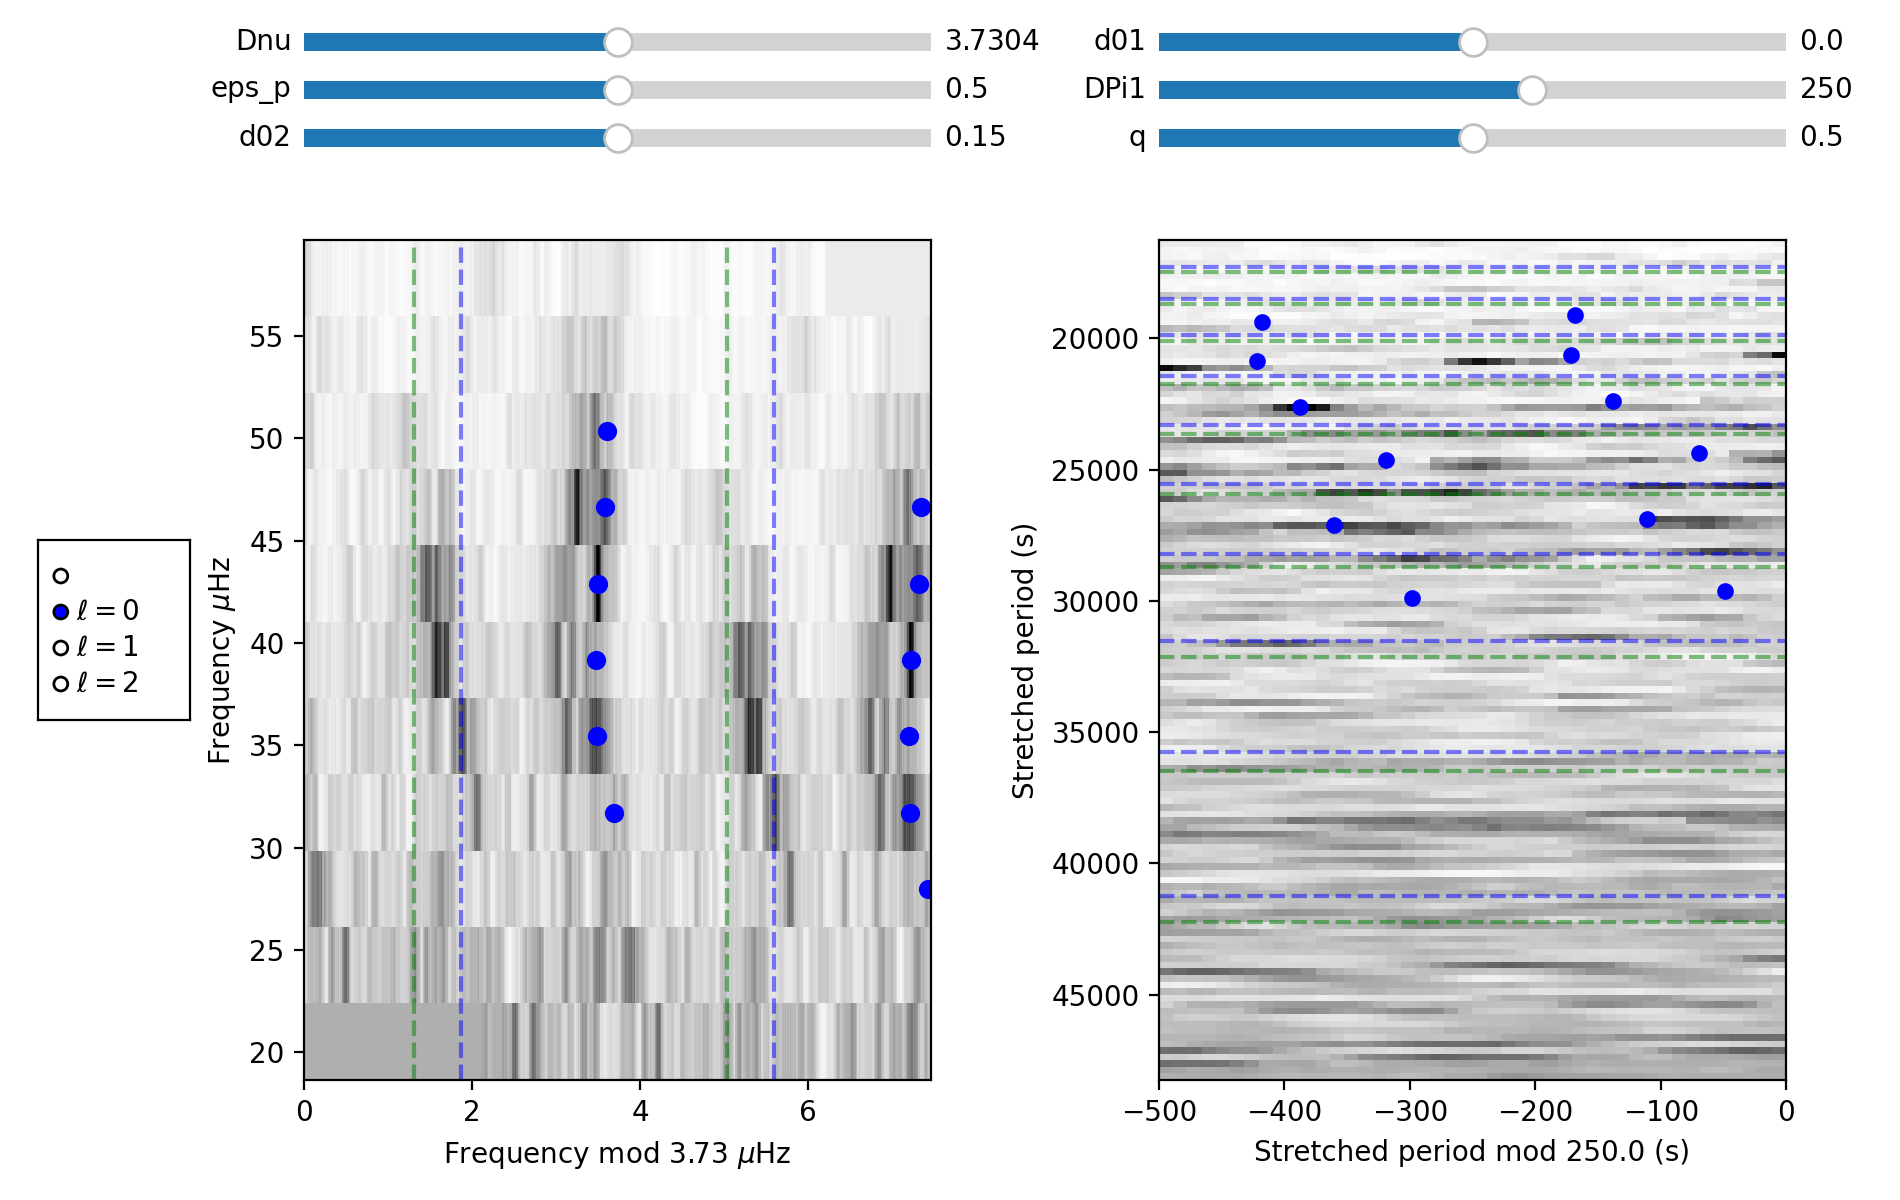

In [44]:
# resample spectrum to have 5000 pixels
# nu = np.linspace(nu_max-5*delta_nu, nu_max+5*delta_nu, 5000)
nu = np.linspace(0.5*nu_max, 1.5*nu_max, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = sew.Star(nu, ps, nu_max, delta_nu,fmin=0.5*nu_max, fmax=1.5*nu_max)

# interactive echelles
star.plot_freq_echelle(snapping=True)#,plot_l1_line=True)
# plt.show()

In [108]:
# star.f_labels

KIC 7175316
delta_nu = 3.730428817
nu_max = 41.48800726
returning dataframes


<IPython.core.display.Javascript object>


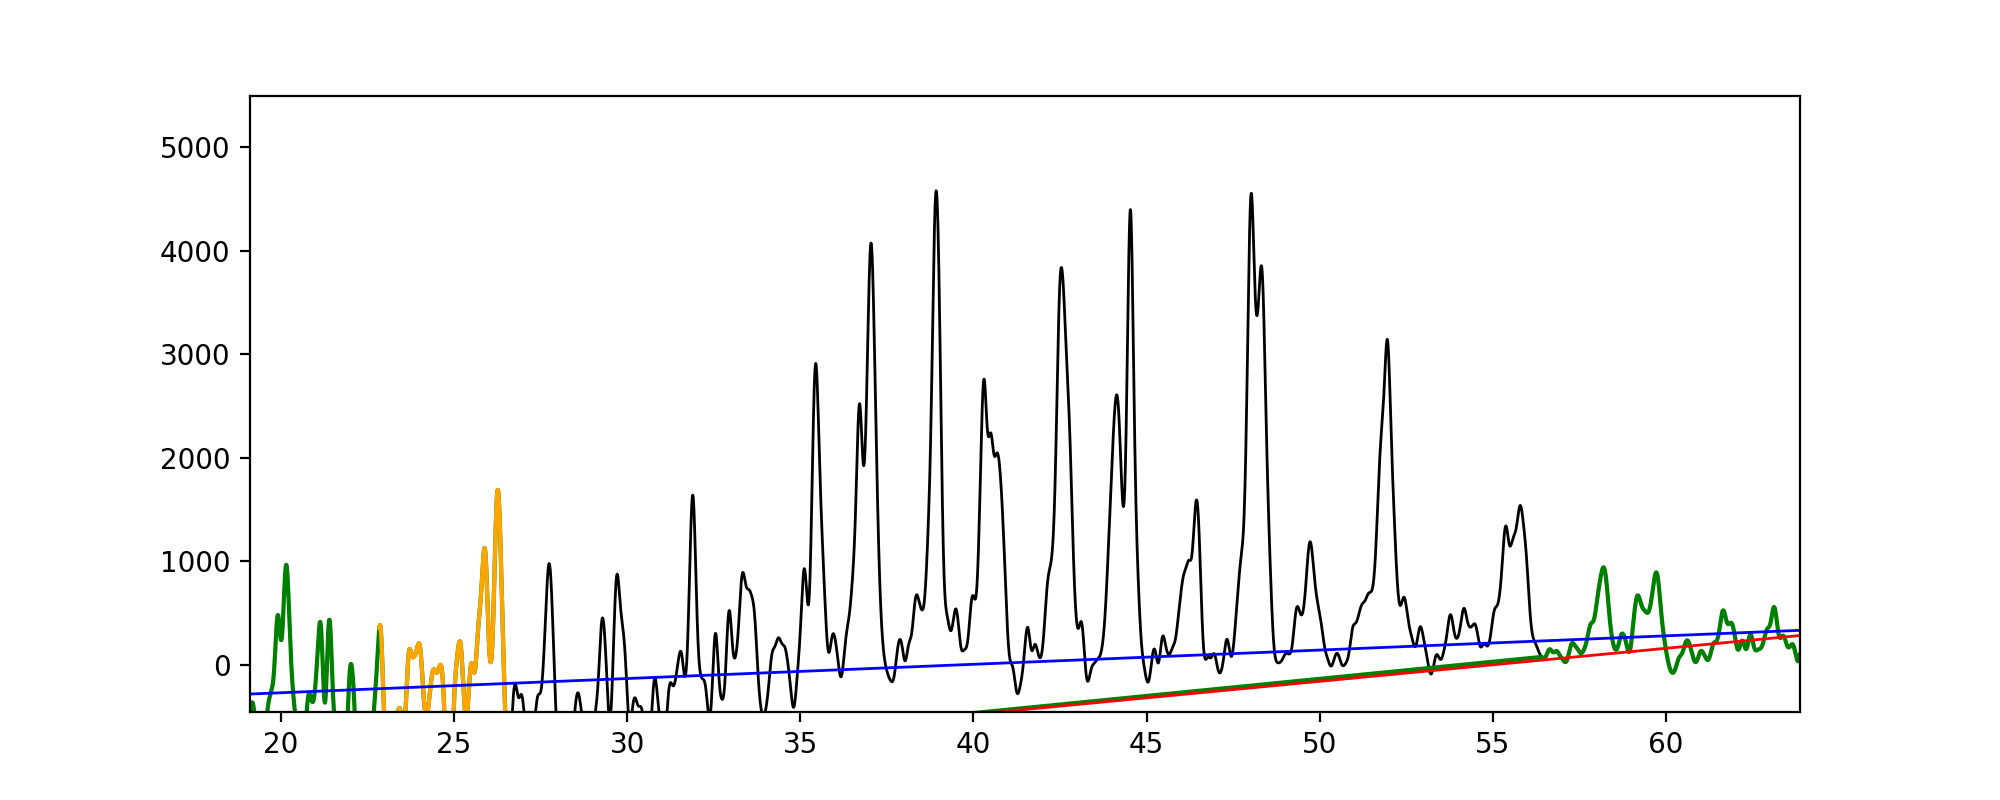

<IPython.core.display.Javascript object>


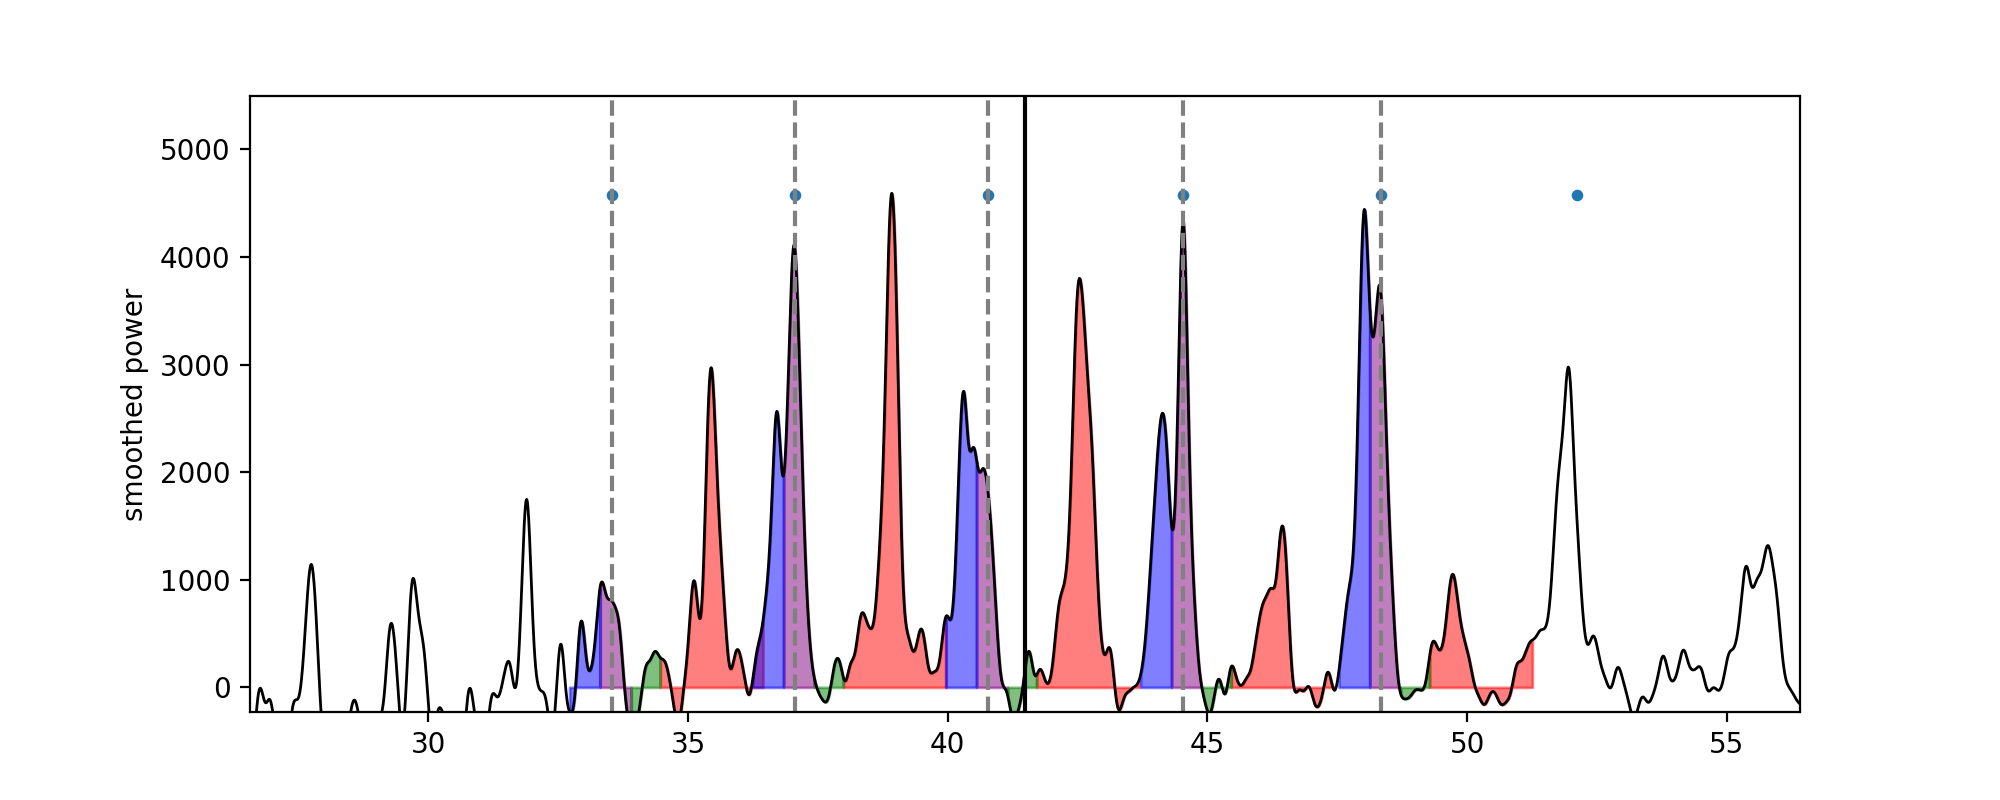

mode amplitudes
-2 33.53316529986598 428.9388706139528 1226.07584974235 173.75660637461434 23.69057280353027
-1 37.06035135417684 1444.2254990864146 2003.65832712555 726.7529924988447 66.5486774627204
0 40.7784204184857 853.0467544396915 1905.1341418881652 1083.3060185888753 -49.86586047658106
1 44.52968652801161 1296.5370683950393 688.7926274784793 928.8072606089905 -55.644594356186
2 48.3473467279716 1539.413134539732 513.6198940442545 1256.3802308050385 -31.658052223040453
mean mode amplitudes
5562.16132707483 6337.2808402788 4169.0031088763635 -46.92925678955683
Visibilites for KIC 7175316
radial amplitude: 5562.16
dipole visiblity: 1.14
quadrupole visiblity: 0.75
octupole visiblity: -0.01
wrote to output dataframe


In [45]:
delta_nu,nu_max,lightcurve,powerspec = read_star_bsps('KIC '+str(kic_number),suppress_output=False)

local_bg_region = np.logical_and(np.abs(powerspec['freq']-nu_max)>4*delta_nu,np.abs(powerspec['freq']-nu_max)<6*delta_nu)
local_bg_region_r = np.logical_and((powerspec['freq']-nu_max)>4*delta_nu,(powerspec['freq']-nu_max)<5*delta_nu)
local_bg_region_l = np.logical_and(-(powerspec['freq']-nu_max)>4*delta_nu,-(powerspec['freq']-nu_max)<5*delta_nu)
popt = np.polyfit(powerspec['freq'][local_bg_region],powerspec['power'][local_bg_region],1)
freq_median = [np.median(powerspec['freq'][local_bg_region_l]),np.median(powerspec['freq'][local_bg_region_r])]
power_median = [np.median(powerspec['power'][local_bg_region_l]),np.median(powerspec['power'][local_bg_region_r])]
popt_median = np.polyfit(freq_median,power_median,1)
# print(popt)
# print(power_median)

freq_res = np.median(np.diff(powerspec['freq']))
smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))

# accounting for asymmetries Stello 2016 (PASA)
l0_halfwidth = 0.08
l2_halfwidth = 0.08
l1_halfwidth = 0.265
l3_halfwidth = 0.075
d02_spacing = 0.14
d01_spacing = 0.515
d03_spacing = 0.175

plt.figure(figsize=(10,4))
plt.plot(powerspec['freq'],smooth_power,color='k',linewidth=1)
plt.plot(powerspec['freq'][local_bg_region],smooth_power[local_bg_region],color='green')
plt.plot(powerspec['freq'][local_bg_region_l],smooth_power[local_bg_region_l],color='orange')
plt.plot(powerspec['freq'],popt[0]*powerspec['freq']+popt[1],color='blue',linewidth=1)
plt.plot(powerspec['freq'],popt_median[0]*powerspec['freq']+popt_median[1],color='red',linewidth=1)
subset = smooth_power[(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(-peak*0.1,peak*1.2)
plt.xlim(nu_max-6*delta_nu,nu_max+6*delta_nu)
# plt.ylim(-100,peak*1.2)
plt.show()

plt.figure(figsize=(10,4))
local_bgcorr_power = powerspec['power']-(popt[0]*powerspec['freq']+popt[1])
local_bgcorr_smooth_power = convolve(local_bgcorr_power,Gaussian1DKernel(0.02*delta_nu/freq_res))
plt.plot(powerspec['freq'],local_bgcorr_smooth_power,color='k',linewidth=1)

# plt.plot(powerspec['freq'],powerspec['power'],color='k',linewidth=1)

# plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
# plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
# plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

###################

def define_regions(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu
    

    plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
#     plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
#     plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
#     plt.fill_between(powerspec['freq'][octupo_region],smooth_power[octupo_region], 0, color='green',alpha=0.5)
    plt.fill_between(powerspec['freq'][radial_region],local_bgcorr_smooth_power[radial_region], 0, color='purple',alpha=0.5)
    plt.fill_between(powerspec['freq'][quadru_region],local_bgcorr_smooth_power[quadru_region], 0, color='blue',alpha=0.5)
    plt.fill_between(powerspec['freq'][dipole_region],local_bgcorr_smooth_power[dipole_region], 0, color='red',alpha=0.5)
    plt.fill_between(powerspec['freq'][octupo_region],local_bgcorr_smooth_power[octupo_region], 0, color='green',alpha=0.5)
    
for i in [-2,-1,0,1,2]:
    define_regions(i)

###################

plt.axvline(nu_max,color='k')
plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
subset = smooth_power[(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(-peak*0.05,peak*1.2)
plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),peak),s=10)
plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),peak),s=10)
plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),peak),s=10)
# plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.savefig('/Users/ccra8514/OneDrive - The University of Sydney (Staff)/work/data/vis_sample/KIC'+str(kic_number),dpi=300,bbox_inches='tight')
plt.show()

print('mode amplitudes')
def find_mode_amps(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu

    # using unsmoothed power here, that seems more right
    # I don't think I need to have the frequency resolution here??
    # need the power density!
#     eff_obs_time = len(lightcurve) * 1800e-6  ##### this might be wrong considering bsps is probably in power density?
    eff_obs_time = 1
#     l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
#                                      y=powerspec['power'][radial_region]*eff_obs_time))#*freq_res
#     l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
#                                      y=powerspec['power'][dipole_region]*eff_obs_time))#*freq_res
#     l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
#                                      y=powerspec['power'][quadru_region]*eff_obs_time))#*freq_res
#     l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
#                                      y=powerspec['power'][octupo_region]*eff_obs_time))#*freq_res
    l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
                                     y=local_bgcorr_power[radial_region]*eff_obs_time))#*freq_res
    l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
                                     y=local_bgcorr_power[dipole_region]*eff_obs_time))#*freq_res
    l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
                                     y=local_bgcorr_power[quadru_region]*eff_obs_time))#*freq_res
    l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
                                     y=local_bgcorr_power[octupo_region]*eff_obs_time))#*freq_res
    print(index,radial_mode,l0_amp,l1_amp,l2_amp,l3_amp)
    return l0_amp,l1_amp,l2_amp,l3_amp

l0_amp_arr = []
l1_amp_arr = []
l2_amp_arr = []
l3_amp_arr = []
for i in [-2,-1,0,1,2]:
    l0,l1,l2,l3 = find_mode_amps(i)
    l0_amp_arr.append(l0)
    l1_amp_arr.append(l1)
    l2_amp_arr.append(l2)
    l3_amp_arr.append(l3)
    
# FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# FWHM = 1
# print(FWHM)
# sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

# def mean_calculation(index=0):
#     radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
#     radial_mode = star.f_labels[0][radial_mode_ind+index]
#     l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
#     quadru_mode = radial_mode - d02_spacing*delta_nu
#     l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
#     dipole_mode = radial_mode + d01_spacing*delta_nu
#     l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
#     octupo_mode = radial_mode + d03_spacing*delta_nu
#     l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
#     return l0_denom,l1_denom,l2_denom,l3_denom

# l0_denom_arr = []
# l1_denom_arr = []
# l2_denom_arr = []
# l3_denom_arr = []
# for i in [-2,-1,0,1,2]:
#     l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
#     l0_denom_arr.append(l0_denom)
#     l1_denom_arr.append(l1_denom)
#     l2_denom_arr.append(l2_denom)
#     l3_denom_arr.append(l3_denom)
# # l0_denom_arr

print('mean mode amplitudes')
mean_l0_amp = np.sum(l0_amp_arr)#/np.sum(l0_denom_arr)
mean_l1_amp = np.sum(l1_amp_arr)#/np.sum(l1_denom_arr)
mean_l2_amp = np.sum(l2_amp_arr)#/np.sum(l2_denom_arr)
mean_l3_amp = np.sum(l3_amp_arr)#/np.sum(l3_denom_arr)
print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

l1_visibility = mean_l1_amp/mean_l0_amp
l2_visibility = mean_l2_amp/mean_l0_amp
l3_visibility = mean_l3_amp/mean_l0_amp
print('Visibilites for KIC',kic_number)
print('radial amplitude:',np.round(mean_l0_amp,2))
print('dipole visiblity:',np.round(l1_visibility,2))
print('quadrupole visiblity:',np.round(l2_visibility,2))
print('octupole visiblity:',np.round(l3_visibility,2))

print('wrote to output dataframe')
star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# type(star_ind)
highmass_rc_newvals['l0_mean_amp'][star_ind] = np.round(mean_l0_amp,2)
highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)
highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)

<IPython.core.display.Javascript object>


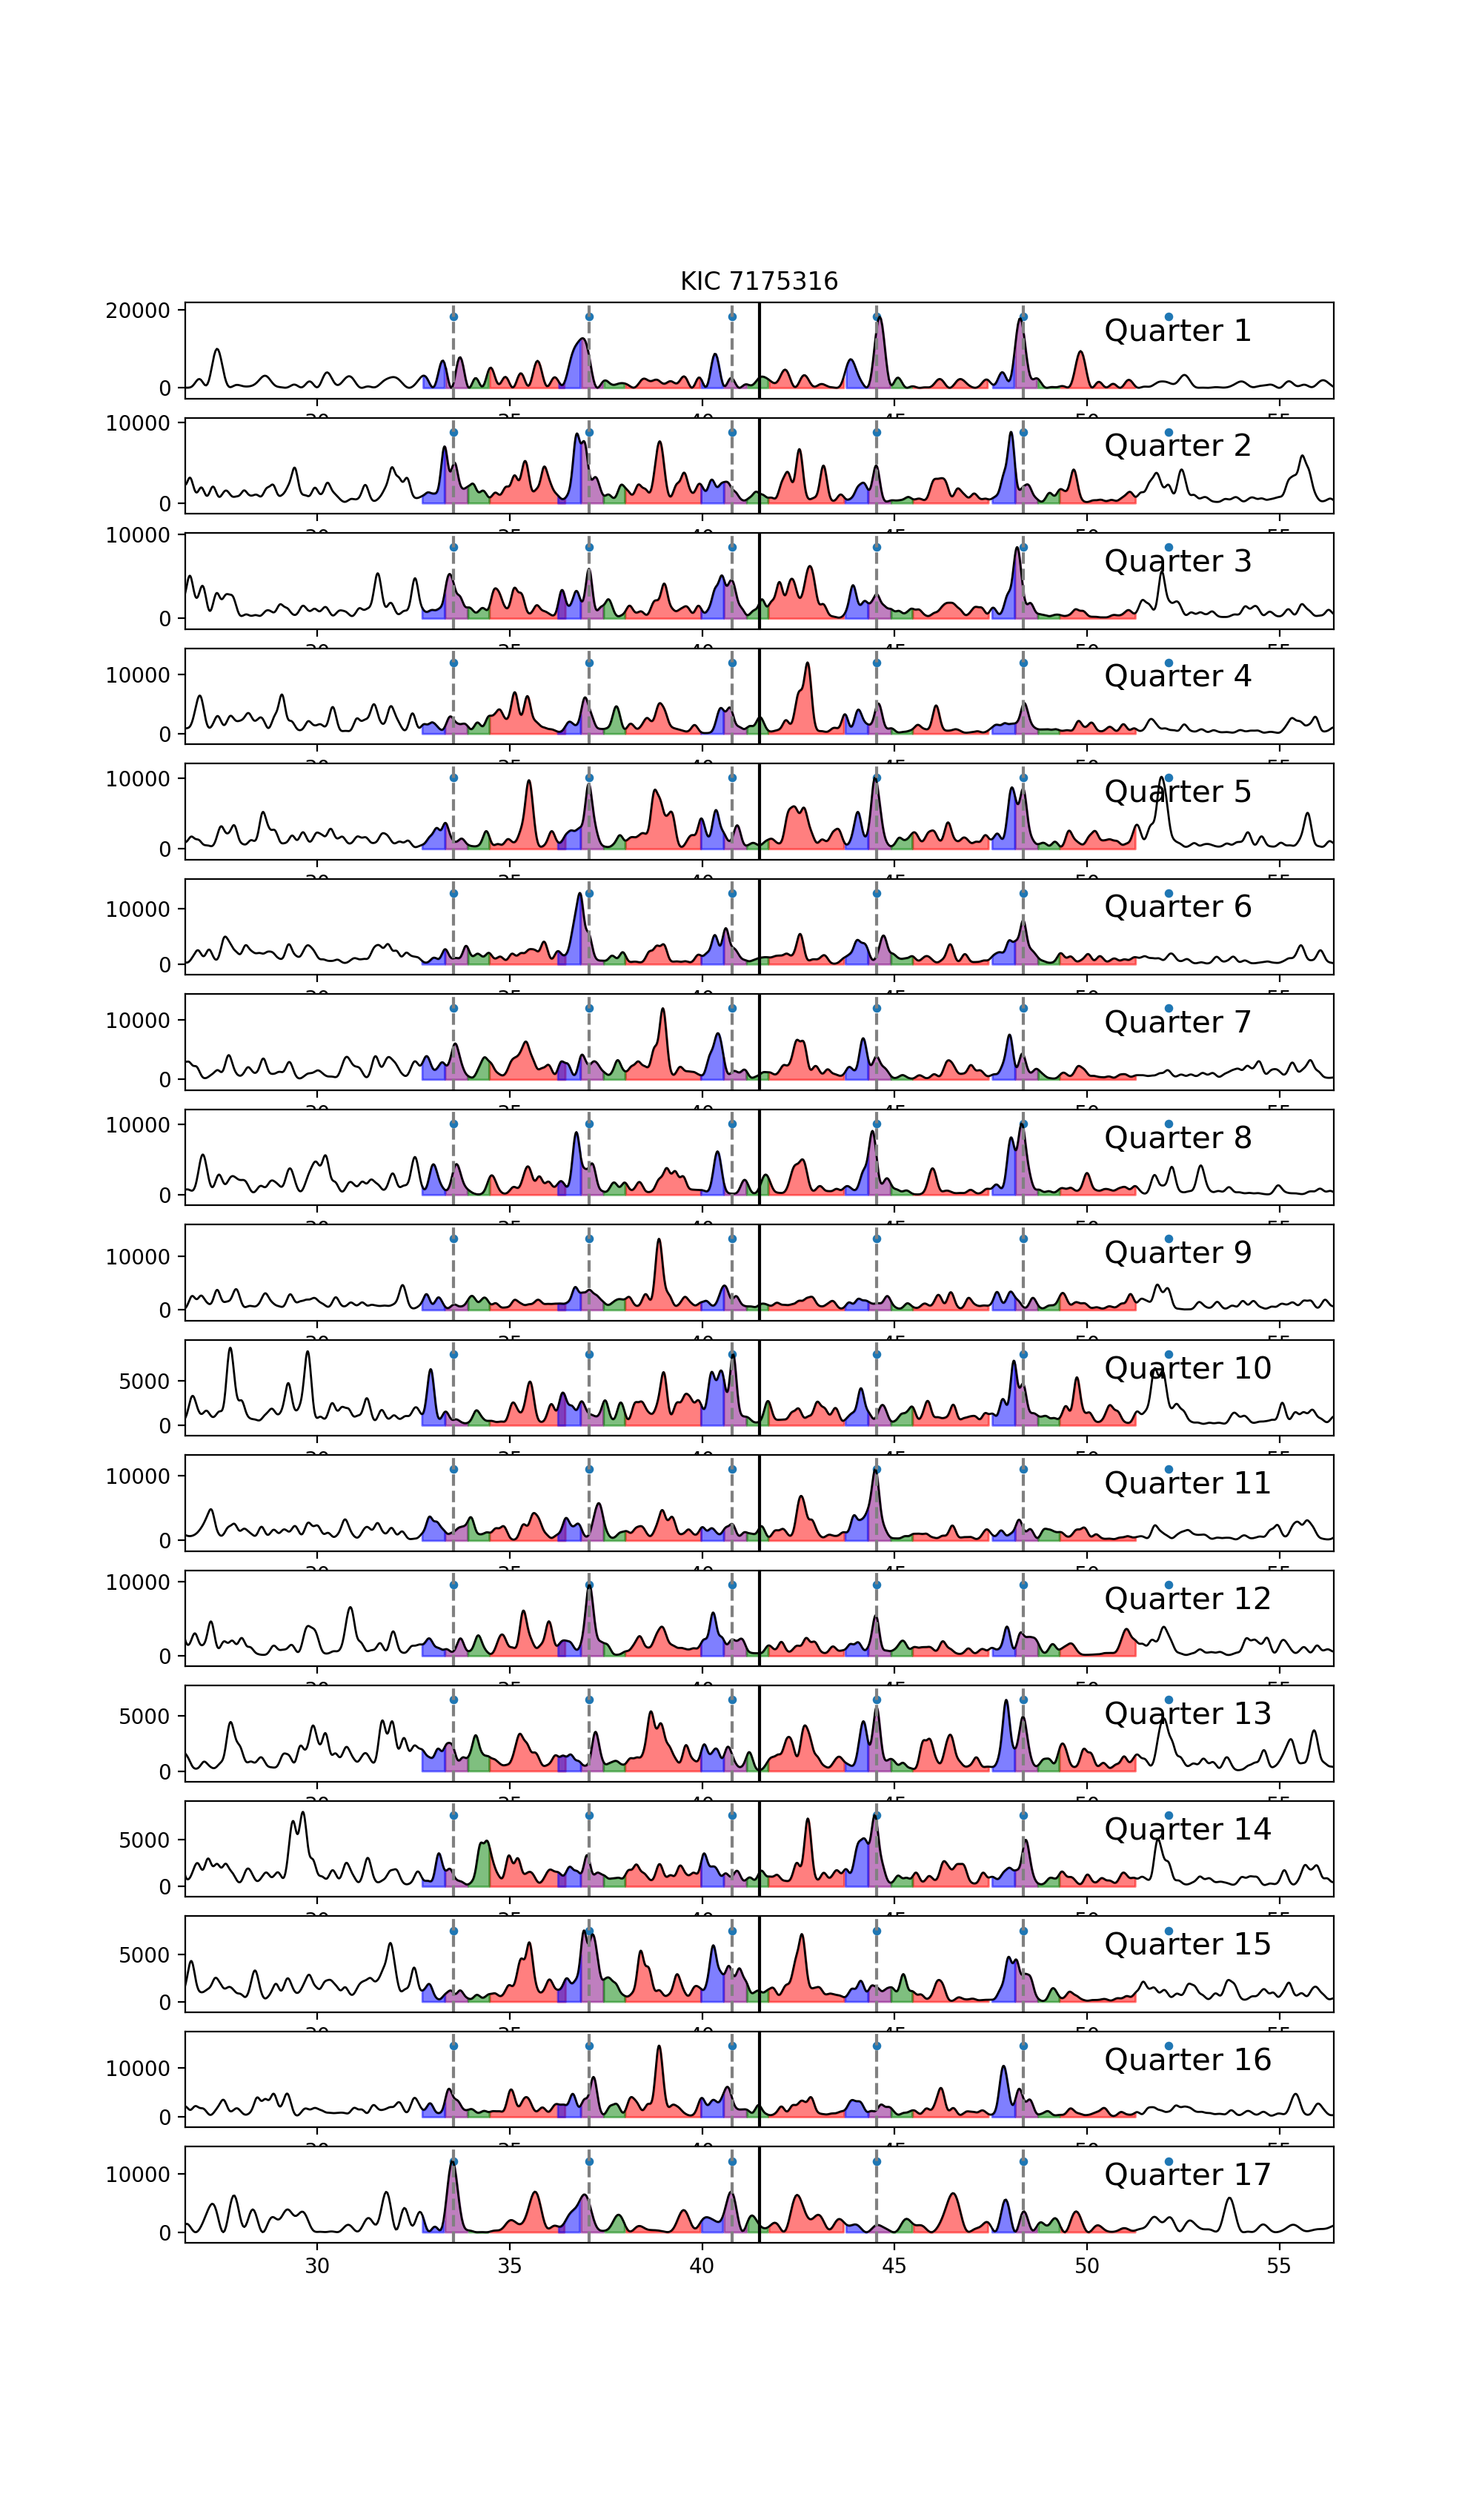

[17660.68, 8948.35, 9587.44, 7957.76, 11749.2, 11020.42, 7905.08, 10062.59, 5676.41, 7582.59, 8361.07, 7593.4, 6067.27, 6599.33, 8630.65, 9943.66, 9687.57]
[0.9, 2.08, 1.57, 2.32, 1.9, 1.23, 2.57, 1.33, 2.78, 2.21, 1.76, 1.86, 2.51, 2.15, 1.63, 1.96, 1.64]
[0.62, 0.9, 0.66, 0.61, 0.72, 0.79, 1.25, 0.87, 1.07, 1.18, 0.76, 0.75, 0.94, 0.92, 0.69, 0.89, 0.53]
[0.18, 0.32, 0.26, 0.47, 0.23, 0.29, 0.36, 0.22, 0.58, 0.43, 0.4, 0.35, 0.46, 0.54, 0.38, 0.32, 0.35]
648.320027302431 0.11779713611034395 0.047158199570046966 0.026107077258940233
wrote to output dataframe


In [76]:
## list of quarter starts and ends
# 0 120.0 131.0
# 1 131.0 165.0
# 2 169.0 259.0
# 3 260.0 350.0
# 4 352.0 443.0
# 5 443.0 539.0
# 6 539.0 630.0
# 7 630.0 720.0
# 8 735.0 803.0
# 9 808.0 906.0
# 10 906.0 1001.0
# 11 1001.0 1099.0
# 12 1099.0 1183.0
# 13 1182.0 1274.0
# 14 1274.0 1372.0
# 15 1373.0 1472.0
# 16 1472.0 1558.0
# 17 1559.0 1592.0

radial_amp_quarter_arr = []
dipole_vis_quarter_arr = []
quadru_vis_quarter_arr = []
octupo_vis_quarter_arr = []

quarter_limits = [[120.0,131.0],[131.0,165.0],[169.0,259.0],[260.0,350.0],[350.0,443.0],[443.0,539.0],
                 [539.0,630.0],[630.0,720.0],[735.0,803.0],[808.0,906.0],[906.0,1001.0],[1001.0,1099.0],
                 [1099.0,1183.0],[1182.0,1274.0],[1274.0,1372.0],[1373.0,1472.0],[1472.0,1558.0],[1559.0,1592.0]]

f, ax = plt.subplots(17,1,figsize=(10,17))
ax[0].set_title('KIC '+str(kic_number))

for x in range(1,18):
#     print('Quarter',x)
    try:
        quarter = lightcurve[np.logical_and(lightcurve['time']>quarter_limits[x][0],
                                            lightcurve['time']<quarter_limits[x][1])]
        quarter_freq,quarter_amp = calc_lomb_scargle(np.asarray(quarter['time']),np.asarray(quarter['flux']))
        quarter_power = quarter_amp**2
        
        eff_obs_time = len(quarter) * 1800e-6
        
        pysyd_bg_model = (harvey_tau(quarter_freq,pysyd_results['tau1'][star_ind],pysyd_results['sigma1'][star_ind])+
                          harvey_tau(quarter_freq,pysyd_results['tau2'][star_ind],pysyd_results['sigma2'][star_ind])+
                          pysyd_results['wn'][star_ind])
        
        quarter_power_bgcorr = (quarter_power*eff_obs_time)-pysyd_bg_model
        
        if x not in [1,17]:
            freq_res = np.median(np.diff(quarter_freq))
            quarter_power_smooth = convolve(quarter_power_bgcorr,Gaussian1DKernel(0.02*delta_nu/freq_res))
        else:
            quarter_power_smooth = quarter_power_bgcorr
        
        local_bg_region_quarter = np.logical_and(np.abs(quarter_freq-nu_max)>4*delta_nu,np.abs(quarter_freq-nu_max)<6*delta_nu)
        popt = np.polyfit(quarter_freq[local_bg_region_quarter],quarter_power_bgcorr[local_bg_region_quarter],1)
#         quarter_local_bgcorr_power = quarter_power-(popt[0]*quarter_freq+popt[1])
#         quarter_local_bgcorr_power = quarter_power-pysyd_bg_model
#         smooth_quarter_local_bgcorr_power = quarter_power_smooth-pysyd_bg_model
        quarter_local_bgcorr_power = quarter_power_bgcorr#-(popt[0]*quarter_freq+popt[1])
        smooth_quarter_local_bgcorr_power = quarter_power_smooth#-(popt[0]*quarter_freq+popt[1])
#         plt.figure(figsize=(10,4))
#         ax[x-1].plot(quarter_freq,quarter_local_bgcorr_power,color='k',linewidth=1)
        ax[x-1].plot(quarter_freq,smooth_quarter_local_bgcorr_power,color='k',linewidth=1)


        ###################

        def define_regions(index=0):
            # pick the radial mode closest to numax
            radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
            radial_mode = star.f_labels[0][radial_mode_ind+index]
            radial_region = np.abs(quarter_freq-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
            # find the other modes based on this
            quadru_mode = radial_mode - d02_spacing*delta_nu
            quadru_region = np.abs(quarter_freq-quadru_mode)<l2_halfwidth*delta_nu
            dipole_mode = radial_mode + d01_spacing*delta_nu
            dipole_region = np.abs(quarter_freq-dipole_mode)<l1_halfwidth*delta_nu
            octupo_mode = radial_mode + d03_spacing*delta_nu
            octupo_region = np.abs(quarter_freq-octupo_mode)<l3_halfwidth*delta_nu


            ax[x-1].axvline(radial_mode,color='grey',linestyle='--')
            ax[x-1].fill_between(quarter_freq[radial_region],smooth_quarter_local_bgcorr_power[radial_region], 0, color='purple',alpha=0.5)
            ax[x-1].fill_between(quarter_freq[quadru_region],smooth_quarter_local_bgcorr_power[quadru_region], 0, color='blue',alpha=0.5)
            ax[x-1].fill_between(quarter_freq[dipole_region],smooth_quarter_local_bgcorr_power[dipole_region], 0, color='red',alpha=0.5)
            ax[x-1].fill_between(quarter_freq[octupo_region],smooth_quarter_local_bgcorr_power[octupo_region], 0, color='green',alpha=0.5)

        for i in [-2,-1,0,1,2]:
            define_regions(i)

        ###################
        ax[x-1].annotate(r'Quarter '+str(x),xy=(0.8,0.6),fontsize=15,xycoords='axes fraction')
        ax[x-1].axvline(nu_max,color='k')
        ax[x-1].set_xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
        subset = quarter_power_smooth[(nu_max*0.8 < quarter_freq) & (quarter_freq < nu_max*1.2)]
        peak = max(subset)
        ax[x-1].set_ylim(-peak*0.15,peak*1.2)
        ax[x-1].scatter(star.f_labels[0],np.full(len(star.f_labels[0]),peak),s=10)
        ax[x-1].scatter(star.f_labels[1],np.full(len(star.f_labels[1]),peak),s=10)
        ax[x-1].scatter(star.f_labels[2],np.full(len(star.f_labels[2]),peak),s=10)
        # plt.ylim(top=5000)
#         ax[x-1].set_ylabel('smoothed power')
#         ax[x-1].show()

#         print('mode amplitudes')
        def find_mode_amps(index=0):
            # pick the radial mode closest to numax
            radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
            radial_mode = star.f_labels[0][radial_mode_ind+index]
            radial_region = np.abs(quarter_freq-radial_mode)<l0_halfwidth*delta_nu
            # find the other modes based on this
            quadru_mode = radial_mode - d02_spacing*delta_nu
            quadru_region = np.abs(quarter_freq-quadru_mode)<l2_halfwidth*delta_nu
            dipole_mode = radial_mode + d01_spacing*delta_nu
            dipole_region = np.abs(quarter_freq-dipole_mode)<l1_halfwidth*delta_nu
            octupo_mode = radial_mode + d03_spacing*delta_nu
            octupo_region = np.abs(quarter_freq-octupo_mode)<l3_halfwidth*delta_nu

            # using unsmoothed power here, that seems more right
            # I don't think I need to have the frequency resolution here??
            eff_obs_time = 1
            l0_amp = (sp.integrate.trapezoid(x=quarter_freq[radial_region],
                                             y=quarter_local_bgcorr_power[radial_region]*eff_obs_time))#*freq_res
            l1_amp = (sp.integrate.trapezoid(x=quarter_freq[dipole_region],
                                             y=quarter_local_bgcorr_power[dipole_region]*eff_obs_time))#*freq_res
            l2_amp = (sp.integrate.trapezoid(x=quarter_freq[quadru_region],
                                             y=quarter_local_bgcorr_power[quadru_region]*eff_obs_time))#*freq_res
            l3_amp = (sp.integrate.trapezoid(x=quarter_freq[octupo_region],
                                             y=quarter_local_bgcorr_power[octupo_region]*eff_obs_time))#*freq_res
        #     print(index,radial_mode,l0_amp,l1_amp,l2_amp,l3_amp)
            return l0_amp,l1_amp,l2_amp,l3_amp

        l0_amp_arr = []
        l1_amp_arr = []
        l2_amp_arr = []
        l3_amp_arr = []
        for i in [-2,-1,0,1,2]:
            l0,l1,l2,l3 = find_mode_amps(i)
            l0_amp_arr.append(l0)
            l1_amp_arr.append(l1)
            l2_amp_arr.append(l2)
            l3_amp_arr.append(l3)

        # FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
        # FWHM = 1
        # print(FWHM)
#         sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

#         def mean_calculation(index=0):
#             radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
#             radial_mode = star.f_labels[0][radial_mode_ind+index]
#             l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
#             quadru_mode = radial_mode - d02_spacing*delta_nu
#             l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
#             dipole_mode = radial_mode + d01_spacing*delta_nu
#             l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
#             octupo_mode = radial_mode + d03_spacing*delta_nu
#             l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
#             return l0_denom,l1_denom,l2_denom,l3_denom

#         l0_denom_arr = []
#         l1_denom_arr = []
#         l2_denom_arr = []
#         l3_denom_arr = []
#         for i in [-2,-1,0,1,2]:
#             l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
#             l0_denom_arr.append(l0_denom)
#             l1_denom_arr.append(l1_denom)
#             l2_denom_arr.append(l2_denom)
#             l3_denom_arr.append(l3_denom)
#         # l0_denom_arr

#         print('mean mode amplitudes')
        mean_l0_amp = np.sum(l0_amp_arr)#/np.sum(l0_denom_arr)
        mean_l1_amp = np.sum(l1_amp_arr)#/np.sum(l1_denom_arr)
        mean_l2_amp = np.sum(l2_amp_arr)#/np.sum(l2_denom_arr)
        mean_l3_amp = np.sum(l3_amp_arr)#/np.sum(l3_denom_arr)
        # print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

        l1_visibility = mean_l1_amp/mean_l0_amp
        l2_visibility = mean_l2_amp/mean_l0_amp
        l3_visibility = mean_l3_amp/mean_l0_amp
#         print('Visibilites for KIC',kic_number)
#         print('radial amplitude:',np.round(mean_l0_amp,2))
#         print('dipole visiblity:',np.round(l1_visibility,2))
#         print('quadrupole visiblity:',np.round(l2_visibility,2))
#         print('octupole visiblity:',np.round(l3_visibility,2))
        
        radial_amp_quarter_arr.append(np.round(mean_l0_amp,2))
        dipole_vis_quarter_arr.append(np.round(l1_visibility,2))
        quadru_vis_quarter_arr.append(np.round(l2_visibility,2))
        octupo_vis_quarter_arr.append(np.round(l3_visibility,2))

        # print('wrote to output dataframe')
        # star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
        # # type(star_ind)
        # highmass_rc_newvals['l0_mean_amp'][star_ind] = np.round(mean_l0_amp,2)
        # highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
        # highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
        # highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)
        # highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)
    except IndexError:
        print('no data for Quarter',x)
#         print('--------------')
        
#     print('--------------')
plt.savefig('/Users/ccra8514/OneDrive - The University of Sydney (Staff)/work/data/vis_quarters/KIC'+str(kic_number)+'_quarters',dpi=300,bbox_inches='tight')
plt.show()
print(radial_amp_quarter_arr)
print(dipole_vis_quarter_arr)
print(quadru_vis_quarter_arr)
print(octupo_vis_quarter_arr)
print(np.std(radial_amp_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),
      np.std(dipole_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),
      np.std(quadru_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),
      np.std(octupo_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)))

print('wrote to output dataframe')
# star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# type(star_ind)
highmass_rc_newvals['e_l0_amp'][star_ind] = np.round(np.std(radial_amp_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),2)
highmass_rc_newvals['e_l1_vis'][star_ind] = np.round(np.std(dipole_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),2)
highmass_rc_newvals['e_l2_vis'][star_ind] = np.round(np.std(quadru_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),2)
highmass_rc_newvals['e_l3_vis'][star_ind] = np.round(np.std(octupo_vis_quarter_arr)/np.sqrt(len(dipole_vis_quarter_arr)),2)
highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)

<IPython.core.display.Javascript object>


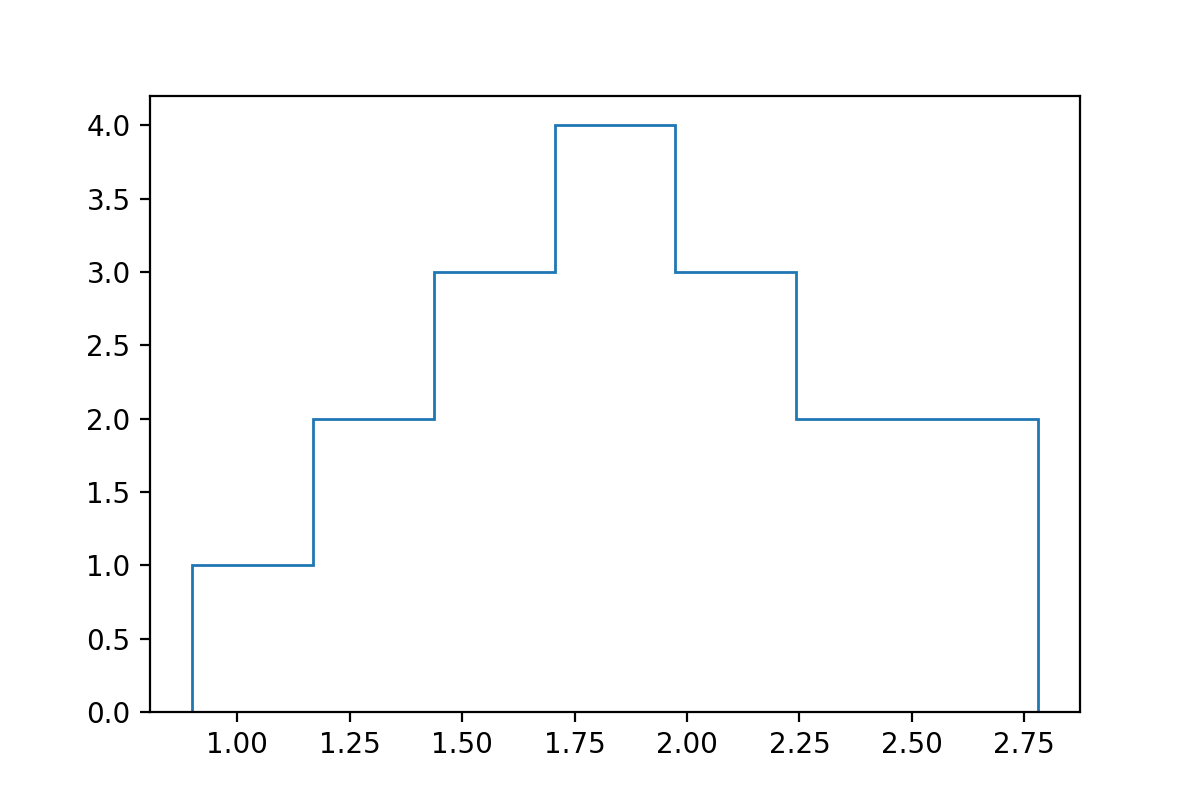

In [75]:
counts, bins = np.histogram(dipole_vis_quarter_arr,bins=7)

plt.figure(figsize=(6,4))
plt.stairs(counts, bins)
plt.show()

KIC 3120567
delta_nu = 5.419966961
nu_max = 65.17183398
returning dataframes


<IPython.core.display.Javascript object>


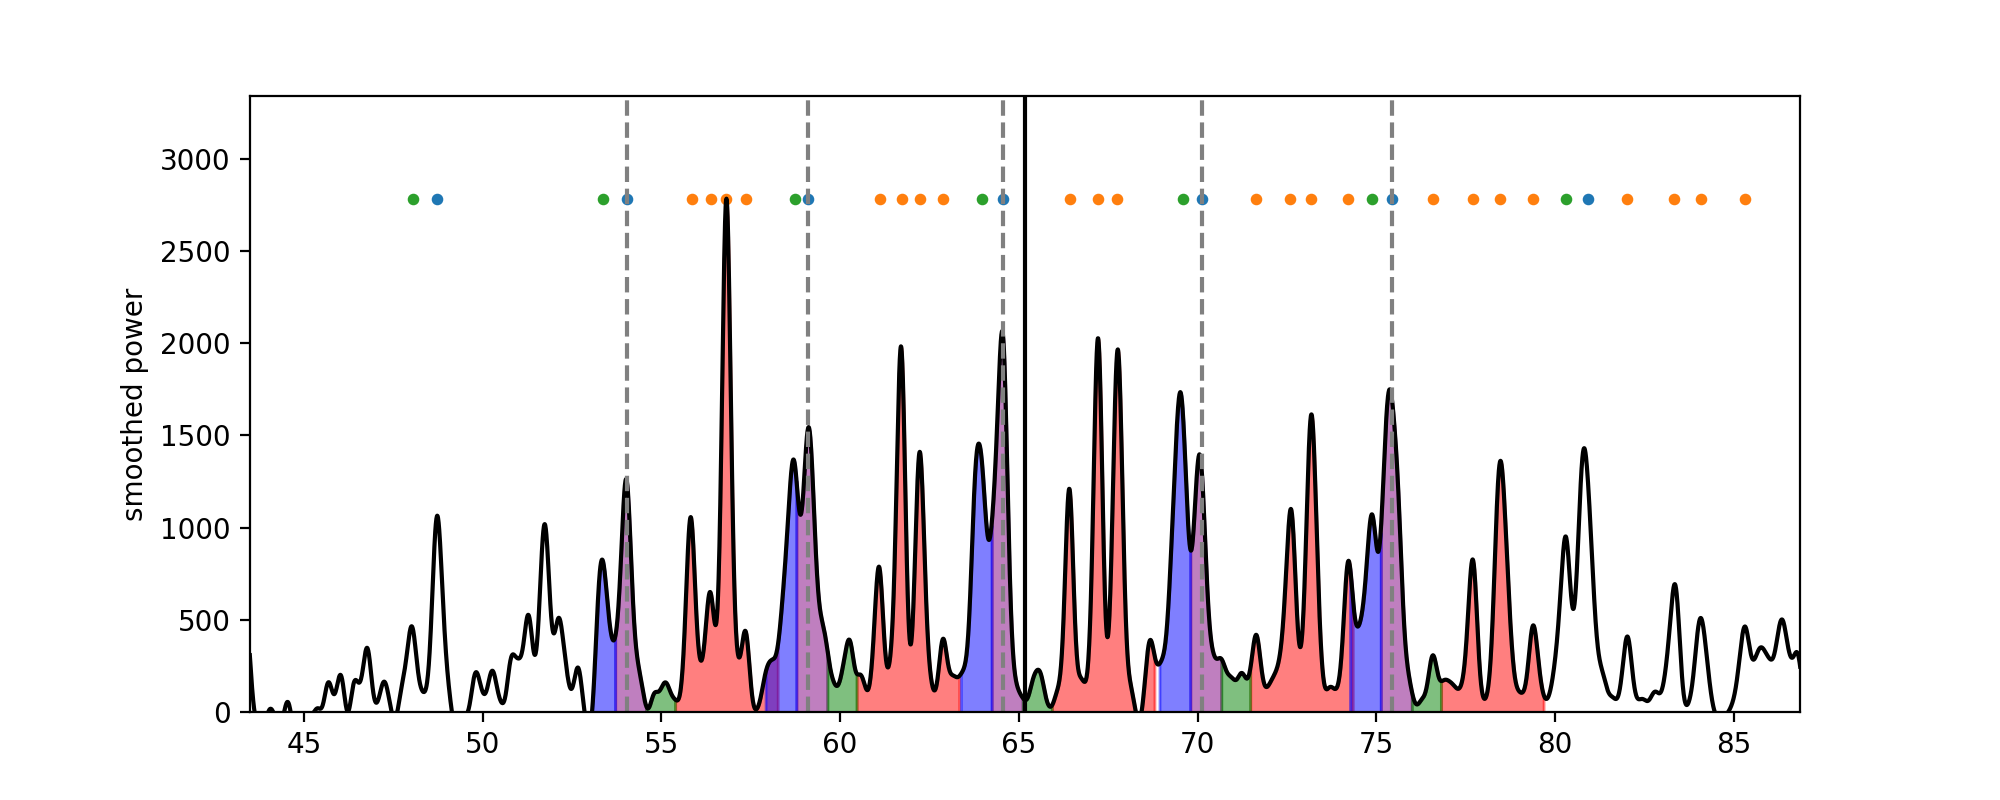

mode amplitudes
521.6467730538498 1575.1480638842538 299.5519739966826 70.04011436279852
873.2176606504876 1492.3721672880897 573.6957522836012 165.85072701979865
887.8549687351091 1709.1520726992007 675.6149325275752 91.6093895003084
659.997467239308 1392.60881353439 826.4142018423818 142.59732733945805
912.295679961566 1061.4244205343082 543.9182283799985 101.25834035596874
mean mode amplitudes
1330.575658199855 2511.6104711107037 1011.5565585386589 196.89282615408743
Visibilites for KIC 3120567
radial amplitude: 1330.58
dipole visiblity: 1.89
quadrupole visiblity: 0.76
octupole visiblity: 0.15
wrote to output dataframe


In [18]:
# delta_nu,nu_max,lightcurve,powerspec = read_star_bsps('KIC '+str(kic_number),suppress_output=False)
# freq_res = np.median(np.diff(powerspec['freq']))
# smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))

# # accounting for asymmetries Stello 2016 (PASA)
# l0_halfwidth = 0.08
# l2_halfwidth = 0.08
# l1_halfwidth = 0.265
# l3_halfwidth = 0.075
# d02_spacing = 0.14
# d01_spacing = 0.515
# d03_spacing = 0.175

# plt.figure(figsize=(10,4))
# plt.plot(powerspec['freq'],smooth_power,color='k')

# # plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
# # plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
# # plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

# ###################

# def define_regions(index=0):
#     # pick the radial mode closest to numax
#     radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
#     radial_mode = star.f_labels[0][radial_mode_ind+index]
#     radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
#     # find the other modes based on this
#     quadru_mode = radial_mode - d02_spacing*delta_nu
#     quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
#     dipole_mode = radial_mode + d01_spacing*delta_nu
#     dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
#     octupo_mode = radial_mode + d03_spacing*delta_nu
#     octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu
    

#     plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
# #     plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
# #     plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
# #     plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][octupo_region],smooth_power[octupo_region], 0, color='green',alpha=0.5)
    
# for i in [-2,-1,0,1,2]:
#     define_regions(i)

# ###################

# plt.axvline(nu_max,color='k')
# plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
# subset = smooth_power[(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
# peak = max(subset)
# plt.ylim(0,peak*1.2)
# plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),peak),s=10)
# plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),peak),s=10)
# plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),peak),s=10)
# # plt.ylim(top=5000)
# plt.ylabel('smoothed power')
# plt.show()

# print('mode amplitudes')
# def find_mode_amps(index=0):
#     # pick the radial mode closest to numax
#     radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
#     radial_mode = star.f_labels[0][radial_mode_ind+index]
#     radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
#     # find the other modes based on this
#     quadru_mode = radial_mode - d02_spacing*delta_nu
#     quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
#     dipole_mode = radial_mode + d01_spacing*delta_nu
#     dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
#     octupo_mode = radial_mode + d03_spacing*delta_nu
#     octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu

#     # using unsmoothed power here, that seems more right
#     # I don't think I need to have the frequency resolution here??
#     # need the power density!
#     eff_obs_time = len(lightcurve) * 1800e-6  ##### this might be wrong considering bsps is probably in power density?
#     l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
#                                      y=powerspec['power'][radial_region]*eff_obs_time))*freq_res
#     l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
#                                      y=powerspec['power'][dipole_region]*eff_obs_time))*freq_res
#     l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
#                                      y=powerspec['power'][quadru_region]*eff_obs_time))*freq_res
#     l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
#                                      y=powerspec['power'][octupo_region]*eff_obs_time))*freq_res
#     print(l0_amp,l1_amp,l2_amp,l3_amp)
#     return l0_amp,l1_amp,l2_amp,l3_amp

# l0_amp_arr = []
# l1_amp_arr = []
# l2_amp_arr = []
# l3_amp_arr = []
# for i in [-2,-1,0,1,2]:
#     l0,l1,l2,l3 = find_mode_amps(i)
#     l0_amp_arr.append(l0)
#     l1_amp_arr.append(l1)
#     l2_amp_arr.append(l2)
#     l3_amp_arr.append(l3)
    
# FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# # FWHM = 1
# # print(FWHM)
# sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

# def mean_calculation(index=0):
#     radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
#     radial_mode = star.f_labels[0][radial_mode_ind+index]
#     l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
#     quadru_mode = radial_mode - d02_spacing*delta_nu
#     l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
#     dipole_mode = radial_mode + d01_spacing*delta_nu
#     l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
#     octupo_mode = radial_mode + d03_spacing*delta_nu
#     l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
#     return l0_denom,l1_denom,l2_denom,l3_denom

# l0_denom_arr = []
# l1_denom_arr = []
# l2_denom_arr = []
# l3_denom_arr = []
# for i in [-2,-1,0,1,2]:
#     l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
#     l0_denom_arr.append(l0_denom)
#     l1_denom_arr.append(l1_denom)
#     l2_denom_arr.append(l2_denom)
#     l3_denom_arr.append(l3_denom)
# # l0_denom_arr

# print('mean mode amplitudes')
# mean_l0_amp = np.sum(l0_amp_arr)/np.sum(l0_denom_arr)
# mean_l1_amp = np.sum(l1_amp_arr)/np.sum(l1_denom_arr)
# mean_l2_amp = np.sum(l2_amp_arr)/np.sum(l2_denom_arr)
# mean_l3_amp = np.sum(l3_amp_arr)/np.sum(l3_denom_arr)
# print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

# l1_visibility = mean_l1_amp/mean_l0_amp
# l2_visibility = mean_l2_amp/mean_l0_amp
# l3_visibility = mean_l3_amp/mean_l0_amp
# print('Visibilites for KIC',kic_number)
# print('radial amplitude:',np.round(mean_l0_amp,2))
# print('dipole visiblity:',np.round(l1_visibility,2))
# print('quadrupole visiblity:',np.round(l2_visibility,2))
# print('octupole visiblity:',np.round(l3_visibility,2))

# print('wrote to output dataframe')
# star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# # type(star_ind)
# highmass_rc_newvals['l0_mean_amp'][star_ind] = np.round(mean_l0_amp,2)
# highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
# highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
# highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)
# highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)

# visibility test

In [8]:
def read_star_vistest(star_name,nu_max,delta_nu,suppress_output=True,unpack=False):
#     delta_nu,nu_max,mass,lc,ps
#     delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#     nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#     mass = adopted_masses['corr_mass'][adopted_masses['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
#         print('Using new values')
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
#         print('Adopted mass =',mass)
    
    lightcurve = pd.read_csv('../data/visibility_tests/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/visibility_tests/KIC'+star_name[4:]+'_PS.csv')
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,lightcurve,powerspec

In [9]:
def read_star_bsps_vistest(star_name,nu_max,delta_nu,suppress_output=True,unpack=False):
#     delta_nu = highmass_rc_newvals['pysyd_dnu'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
#     nu_max = highmass_rc_newvals['pysyd_numax'][highmass_rc_newvals['KIC']==float(star_name[4:])].values[0]
    if suppress_output == False:
        print(star_name)
        print('delta_nu =',delta_nu)
        print('nu_max =',nu_max)
    
    lightcurve = pd.read_csv('../data/visibility_tests/KIC'+star_name[4:]+'_LC.csv')
    powerspec = pd.read_csv('../data/visibility_tests/'+star_name[4:]+'/'+star_name[4:]+'_BSPS.txt', 
                            delimiter='\s+', names=['freq','power'])
    if unpack == True:
        if suppress_output == False:
            print('unpacking data frames')
        time = np.asarray(lightcurve['time'])
        flux = np.asarray(lightcurve['flux'])
        freq = np.asarray(powerspec['freq'])
        power = np.asarray(powerspec['power'])
        amp = np.asarray(powerspec['amp'])
        return delta_nu,nu_max,time,flux,freq,power,amp
    else:
        if suppress_output == False:
            print('returning dataframes')
        return delta_nu,nu_max,lightcurve,powerspec

In [10]:
test_data = pd.read_csv('../data/visibility_tests/kplr002141255-q0q1q2q3q4q5q6q7q8q9q10q11q12q13q14_llc.dat.ts.fft.pds.bgcorr',
                       names=['freq','power'],sep='\s+')
test_data

freq     power
0         0.001851  0.000000
1         0.003701  0.000000
2         0.005552  0.000000
3         0.007403  0.000000
4         0.009253  0.000000
...            ...       ...
151289  279.991368  0.483496
151290  279.993219  0.668603
151291  279.995070  0.837609
151292  279.996920  0.961341
151293  279.998771  1.044221

[151294 rows x 2 columns]

In [84]:
# plt.figure(figsize=(10,4))
# plt.plot(test_data['freq'],test_data['power'])
# plt.xlabel('frequency (uhz)')
# plt.ylabel('bg divided power')
# plt.xlim(100,200)
# plt.show()

In [83]:
# plt.figure(figsize=(10,4))
# plt.plot(powerspec['freq'],powerspec['power'])
# plt.xlabel('frequency (uhz)')
# plt.ylabel('bg subtracted power density')
# plt.xlim(100,200)
# plt.show()

In [101]:
# 2141255   147.82   12.371
# 4348666   182.87   13.927
# 2305987   52.571   5.489
# 1296068   58.740   6.127

# 12453551  51.368   5.001
# 1164301   57.333   5.966
# 12645606  53.796   5.830
# 2837276   56.419   5.740

kic_number = 12645606
delta_nu,nu_max,lightcurve,powerspec = read_star_vistest('KIC '+str(kic_number),53.796,5.830,suppress_output=False)

freq = powerspec['freq']
power = powerspec['power']

smooth_percent = 0.02
freq_res = np.median(np.diff(freq))
smoothed_power = convolve(power, Box1DKernel((delta_nu*smooth_percent)/freq_res))

KIC 12645606
delta_nu = 5.83
nu_max = 53.796
returning dataframes


<IPython.core.display.Javascript object>


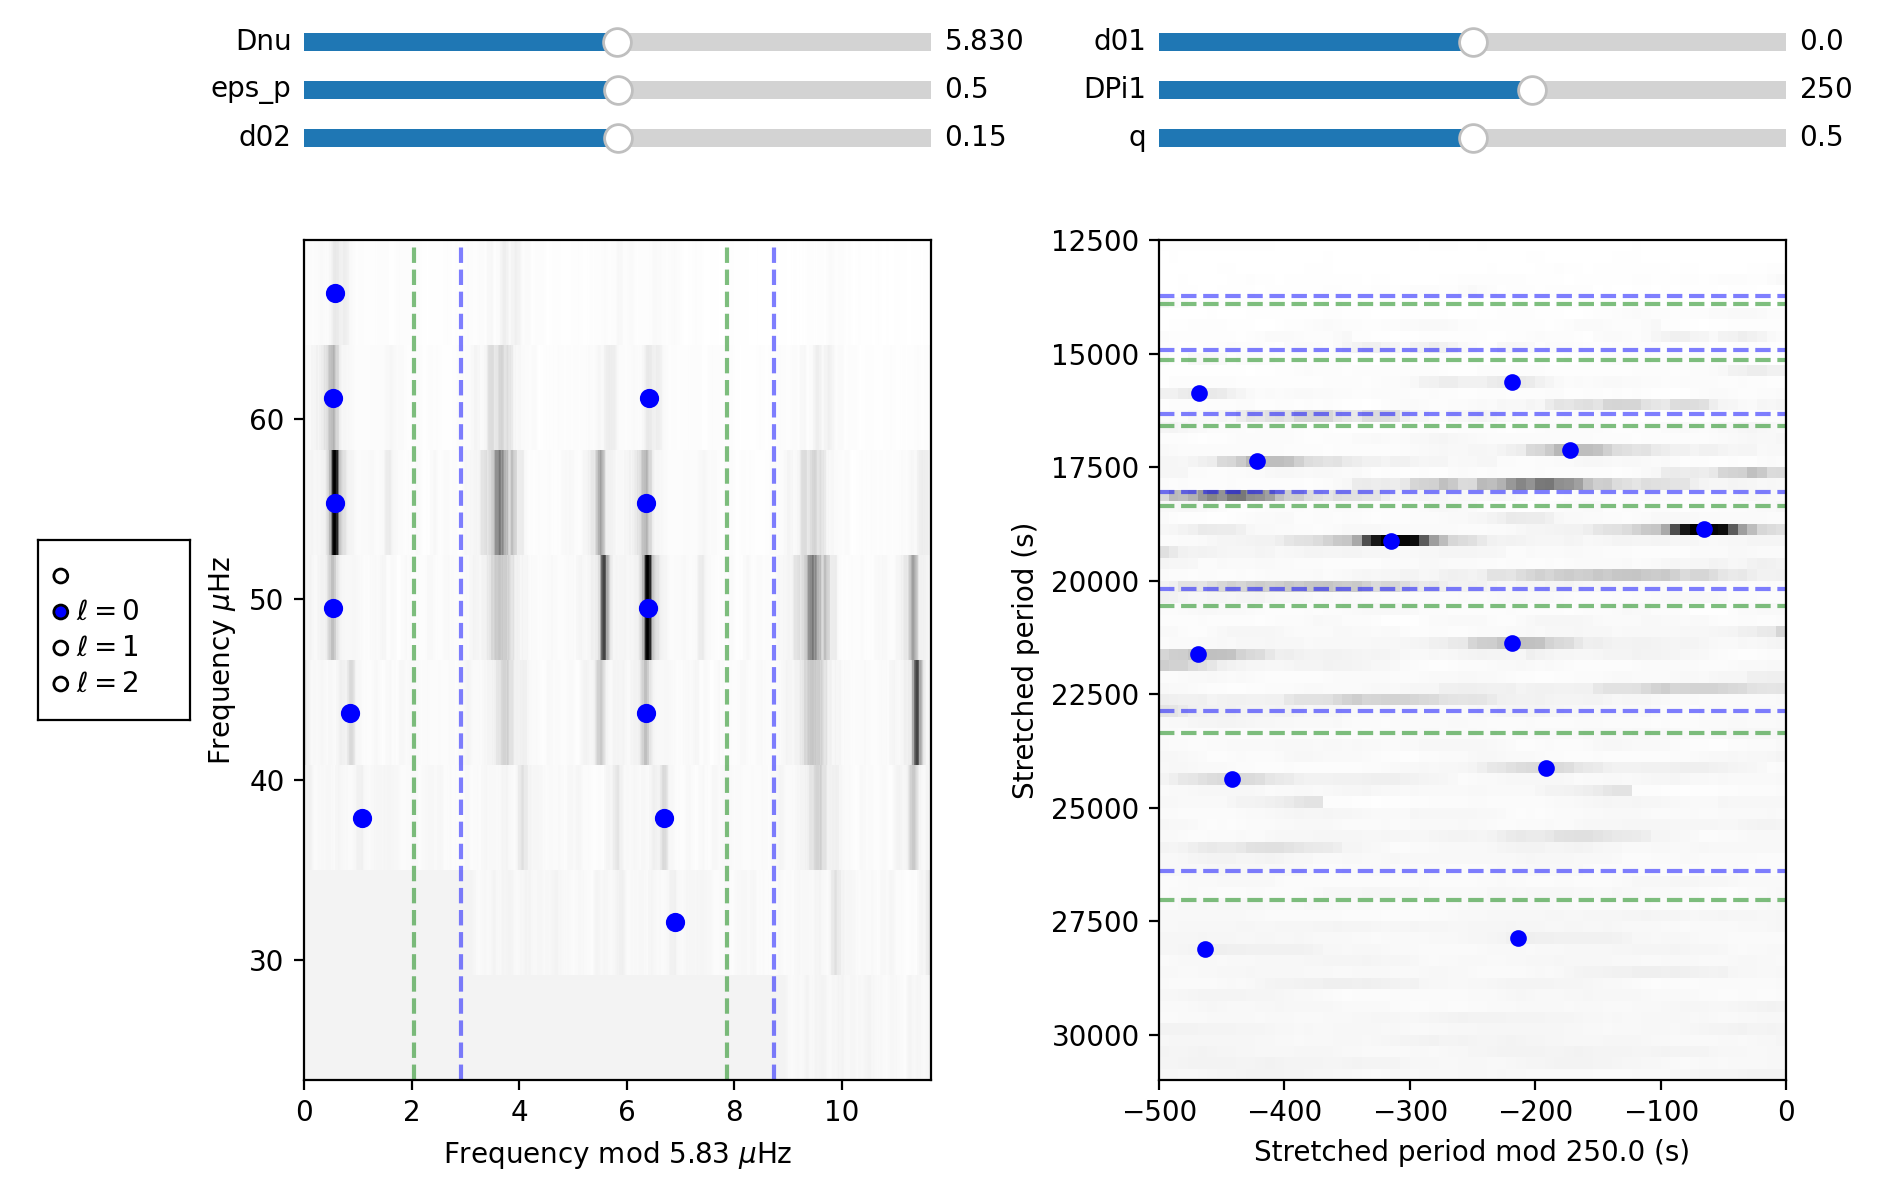

In [102]:
# resample spectrum to have 5000 pixels
# nu = np.linspace(nu_max-5*delta_nu, nu_max+5*delta_nu, 5000)
nu = np.linspace(0.5*nu_max, 1.5*nu_max, 5000)
ps = np.interp(nu, freq, smoothed_power)

# initiate a star object
star = sew.Star(nu, ps, nu_max, delta_nu,fmin=0.6*nu_max, fmax=1.5*nu_max)

# interactive echelles
star.plot_freq_echelle(snapping=True)#,plot_l1_line=True)
# plt.show()

In [103]:
yu_catalog = pd.read_csv('../datatables/yu2018_catalog_werr.csv')

FWHM = yu_catalog['Width'][yu_catalog['KIC']==kic_number].values[0]
FWHM

17.0

KIC 12645606
delta_nu = 5.83
nu_max = 53.796
returning dataframes


<IPython.core.display.Javascript object>


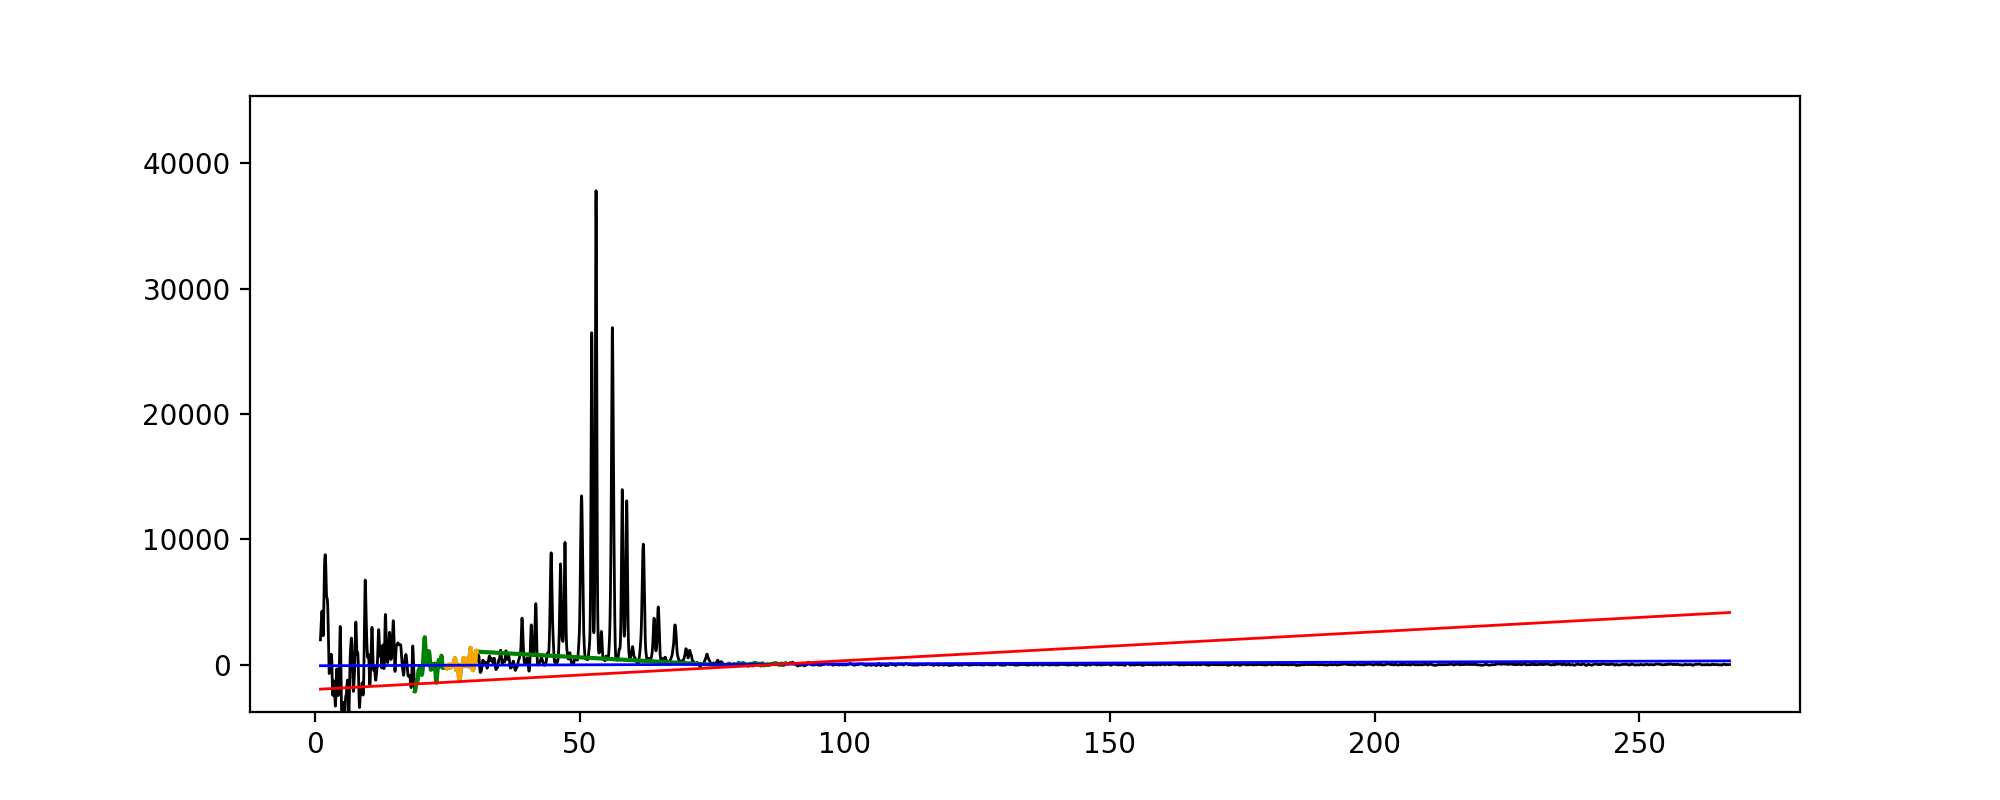

<IPython.core.display.Javascript object>


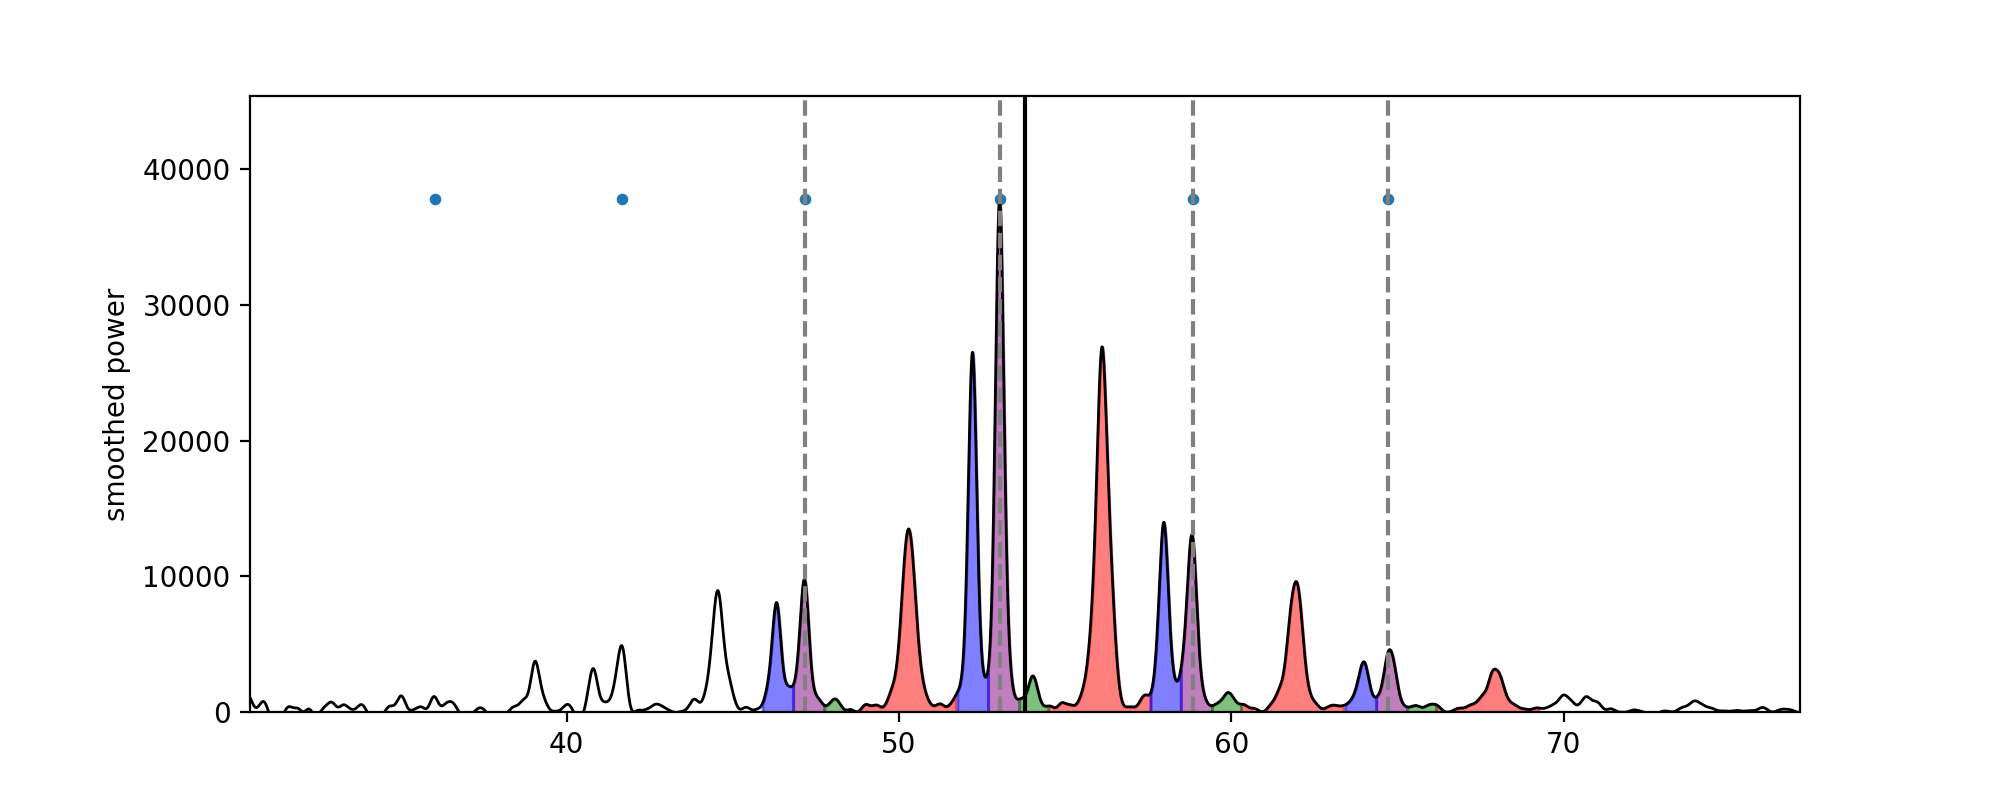

mode amplitudes
-1 47.17238767753551 4009.6181630517453 8404.51443436209 3519.711584574178 447.0781752342016
0 53.03732466493299 13375.741238270726 15142.116735880225 9600.512203858947 1195.4851692033005
1 58.83769353870774 5631.519552003394 6339.050932911997 5710.602870484755 768.051271171334
2 64.71339187837567 2277.6764455459665 2641.4439652201577 1786.833967859422 385.2736536068494
mean mode amplitudes
25294.555398871835 32527.12606837447 20617.660626777302 2795.888269215686
Visibilites for KIC 12645606
radial amplitude: 25294.56
dipole visiblity: 1.29
quadrupole visiblity: 0.82
octupole visiblity: 0.11


In [104]:
delta_nu,nu_max,lightcurve,powerspec = read_star_bsps_vistest('KIC '+str(kic_number),
                                                              nu_max,delta_nu,suppress_output=False)

local_bg_region = np.logical_and(np.abs(powerspec['freq']-nu_max)>4*delta_nu,np.abs(powerspec['freq']-nu_max)<6*delta_nu)
local_bg_region_r = np.logical_and((powerspec['freq']-nu_max)>4*delta_nu,(powerspec['freq']-nu_max)<5*delta_nu)
local_bg_region_l = np.logical_and(-(powerspec['freq']-nu_max)>4*delta_nu,-(powerspec['freq']-nu_max)<5*delta_nu)
popt = np.polyfit(powerspec['freq'][local_bg_region],powerspec['power'][local_bg_region],1)
freq_median = [np.median(powerspec['freq'][local_bg_region_l]),np.median(powerspec['freq'][local_bg_region_r])]
power_median = [np.median(powerspec['power'][local_bg_region_l]),np.median(powerspec['power'][local_bg_region_r])]
popt_median = np.polyfit(freq_median,power_median,1)
# print(popt)
# print(power_median)

freq_res = np.median(np.diff(powerspec['freq']))
smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))

# accounting for asymmetries Stello 2016 (PASA)
l0_halfwidth = 0.08
l2_halfwidth = 0.08
l1_halfwidth = 0.265
l3_halfwidth = 0.075
d02_spacing = 0.14
d01_spacing = 0.515
d03_spacing = 0.175

plt.figure(figsize=(10,4))
plt.plot(powerspec['freq'],smooth_power,color='k',linewidth=1)
plt.plot(powerspec['freq'][local_bg_region],smooth_power[local_bg_region],color='green')
plt.plot(powerspec['freq'][local_bg_region_l],smooth_power[local_bg_region_l],color='orange')
plt.plot(powerspec['freq'],popt[0]*powerspec['freq']+popt[1],color='blue',linewidth=1)
plt.plot(powerspec['freq'],popt_median[0]*powerspec['freq']+popt_median[1],color='red',linewidth=1)
subset = smooth_power[(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(-peak*0.1,peak*1.2)
# plt.ylim(-100,peak*1.2)
plt.show()

plt.figure(figsize=(10,4))
local_bgcorr_power = powerspec['power']-(popt[0]*powerspec['freq']+popt[1])
local_bgcorr_smooth_power = convolve(local_bgcorr_power,Gaussian1DKernel(0.02*delta_nu/freq_res))
plt.plot(powerspec['freq'],local_bgcorr_smooth_power,color='k',linewidth=1)

# plt.plot(powerspec['freq'],powerspec['power'],color='k',linewidth=1)

# plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
# plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
# plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

###################

def define_regions(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu
    

    plt.axvline(radial_mode,color='grey',linestyle='--')
#     plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
#     plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
#     plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
#     plt.fill_between(powerspec['freq'][octupo_region],smooth_power[octupo_region], 0, color='green',alpha=0.5)
    plt.fill_between(powerspec['freq'][radial_region],local_bgcorr_smooth_power[radial_region], 0, color='purple',alpha=0.5)
    plt.fill_between(powerspec['freq'][quadru_region],local_bgcorr_smooth_power[quadru_region], 0, color='blue',alpha=0.5)
    plt.fill_between(powerspec['freq'][dipole_region],local_bgcorr_smooth_power[dipole_region], 0, color='red',alpha=0.5)
    plt.fill_between(powerspec['freq'][octupo_region],local_bgcorr_smooth_power[octupo_region], 0, color='green',alpha=0.5)
    
for i in [-1,0,1,2]:
    define_regions(i)

###################

plt.axvline(nu_max,color='k')
plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
subset = smooth_power[(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.2)
plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),peak),s=10)
plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),peak),s=10)
plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),peak),s=10)
# plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.show()

print('mode amplitudes')
def find_mode_amps(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu

    # using unsmoothed power here, that seems more right
    # I don't think I need to have the frequency resolution here??
    # need the power density!
#     eff_obs_time = len(lightcurve) * 1800e-6  ##### this might be wrong considering bsps is probably in power density?
    eff_obs_time = 1
#     l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
#                                      y=powerspec['power'][radial_region]*eff_obs_time))#*freq_res
#     l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
#                                      y=powerspec['power'][dipole_region]*eff_obs_time))#*freq_res
#     l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
#                                      y=powerspec['power'][quadru_region]*eff_obs_time))#*freq_res
#     l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
#                                      y=powerspec['power'][octupo_region]*eff_obs_time))#*freq_res
    l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
                                     y=local_bgcorr_power[radial_region]*eff_obs_time))#*freq_res
    l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
                                     y=local_bgcorr_power[dipole_region]*eff_obs_time))#*freq_res
    l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
                                     y=local_bgcorr_power[quadru_region]*eff_obs_time))#*freq_res
    l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
                                     y=local_bgcorr_power[octupo_region]*eff_obs_time))#*freq_res
    print(index,radial_mode,l0_amp,l1_amp,l2_amp,l3_amp)
    return l0_amp,l1_amp,l2_amp,l3_amp

l0_amp_arr = []
l1_amp_arr = []
l2_amp_arr = []
l3_amp_arr = []
for i in [-1,0,1,2]:
    l0,l1,l2,l3 = find_mode_amps(i)
    l0_amp_arr.append(l0)
    l1_amp_arr.append(l1)
    l2_amp_arr.append(l2)
    l3_amp_arr.append(l3)
    
# FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# FWHM = 1
# print(FWHM)
sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

def mean_calculation(index=0):
    radial_mode_ind = np.argmin(np.abs(np.asarray(star.f_labels[0])-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
    quadru_mode = radial_mode - d02_spacing*delta_nu
    l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
    dipole_mode = radial_mode + d01_spacing*delta_nu
    l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
    octupo_mode = radial_mode + d03_spacing*delta_nu
    l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
    return l0_denom,l1_denom,l2_denom,l3_denom

l0_denom_arr = []
l1_denom_arr = []
l2_denom_arr = []
l3_denom_arr = []
for i in [-1,0,1,2]:
    l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
    l0_denom_arr.append(l0_denom)
    l1_denom_arr.append(l1_denom)
    l2_denom_arr.append(l2_denom)
    l3_denom_arr.append(l3_denom)
# l0_denom_arr

print('mean mode amplitudes')
mean_l0_amp = np.sum(l0_amp_arr)#/np.sum(l0_denom_arr)
mean_l1_amp = np.sum(l1_amp_arr)#/np.sum(l1_denom_arr)
mean_l2_amp = np.sum(l2_amp_arr)#/np.sum(l2_denom_arr)
mean_l3_amp = np.sum(l3_amp_arr)#/np.sum(l3_denom_arr)
print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

l1_visibility = mean_l1_amp/mean_l0_amp
l2_visibility = mean_l2_amp/mean_l0_amp
l3_visibility = mean_l3_amp/mean_l0_amp
print('Visibilites for KIC',kic_number)
print('radial amplitude:',np.round(mean_l0_amp,2))
print('dipole visiblity:',np.round(l1_visibility,2))
print('quadrupole visiblity:',np.round(l2_visibility,2))
print('octupole visiblity:',np.round(l3_visibility,2))

# print('wrote to output dataframe')
# star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# # type(star_ind)
# highmass_rc_newvals['l0_mean_amp'][star_ind] = np.round(mean_l0_amp,2)
# highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
# highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
# highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)
# highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)

In [91]:
# star.f_labels

# Extra stuff with the output

In [10]:
from scipy.optimize import curve_fit
from scipy.optimize import minimize,basinhopping

In [11]:
def lorentzian(x, amplitude, center, width):
    return (amplitude*width**2/((x-center)**2+width**2))

def peakbag(l,freq_list,freq,power,dnu):
    #want to fit a lorentzian to the region around the clicked peak
    for f in freq_list:
        # probably want to mask around the peak itself
        power_region = power[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        freq_region = freq[(f-(dnu*0.07) < freq) & (freq < f+(dnu*0.07))]
        
        popt, pcov = curve_fit(lorentzian, freq_region, power_region,
                               p0=[max(power_region), f, 0.1])#,
#                               bounds=([0, 0, 0.05], np.inf))
        perr = np.sqrt(np.diag(pcov))
    
        def minus_log_likelihood(theta, freq, power):
            amp, cen, wid, bg = theta
            model = lorentzian(freq,amp,cen,wid) + bg
            return np.sum(np.log(model) + power/model)
        bnds = ((0, None), None, None, None)
#         res = minimize(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
#                        args=(freq_region,power_region), bounds=bnds)
        kwargs = dict({'args':(freq_region,power_region),'method':'BFGS','bounds':bnds})
        res = basinhopping(minus_log_likelihood, [max(power_region), f, 0.1, 1], 
                       minimizer_kwargs=kwargs) # note that BFGS doesn't take bounds so this will have to change
        err = np.sqrt(np.diag(res.lowest_optimization_result.hess_inv))
    
        print('------- CURVE FIT VALUES --------')
        print('Amplitude:',np.round(popt[0],2),'+/-',np.round(perr[0],2))
        print('Center:',np.round(popt[1],2),'+/-',np.round(perr[1],2))
        print('Width:',np.round(popt[2],4),'+/-',np.round(perr[2],4))
        
        print('------- MINIMIZE VALUES ---------')
        print('Amplitude:',np.round(res.x[0],2),'+/-',np.round(err[0],2))
        print('Center:',np.round(res.x[1],2),'+/-',np.round(err[1],2))
        print('Width:',np.round(res.x[2],4),'+/-',np.round(err[2],4))
        print('BG:',np.round(res.x[3],1),'+/-',np.round(err[3],2))
        
#         print(res.lowest_optimization_result.hess_inv)
        
        fig = plt.figure(figsize=(4,2))
        plt.plot(freq_region,power_region,label='data')
        plt.plot(freq_region,lorentzian(freq_region,*popt),
                 linestyle='--',label='curve fit')
        plt.plot(freq_region,lorentzian(freq_region,*res.x[:-1]),
                 linestyle='--',label='minimize fit')
        plt.legend()
        plt.xlabel(r'Frequency ($\mu$Hz)')
        plt.ylabel('Power')
        plt.show()
        
def estimate_dpi(freq_list,numax,dnu):
    # a very back of the envelope estimate
#     freq_list = np.sort(freq_list)
    df = np.diff(freq_list)
    # only take the frequencies next to each other
    df = df[df < dnu*0.5]
    dpi = df/(numax**2) * 1e6
    print('All Dpis:',dpi)
    print('Average Dpi:',np.average(dpi))
    print('Average Dpi:',np.average(dpi))

In [12]:
estimate_dpi(star.f_labels[1],star.numax,star.Dnu)

All Dpis: []
Average Dpi: nan
Average Dpi: nan


In [13]:
# peakbag(1,star.f_labels[1],freq,power,star.Dnu)

# Mode Visibilities

$$A_{0}^{2}(n) = \delta \nu \int_{n-e_{20}}^{n+e_{03}}[p(n')-B]dn'$$
where p = power density, B = local background, $\delta \nu$ the frequency resolution   
where also $e_{12}$ = -0.22, $e_{20}$ = -0.065, $e_{03}$ = 0.17, $e_{31}$ = 0.27   
then   
$$\langle A_{\ell}^{2} \rangle = \sum_{n_{max}-2}^{n_{max}+2} A_{\ell}^{2}(n)/ \sum_{n_{max}-2}^{n_{max}+2} exp[\frac{-(\nu_{n,\ell}-\nu_{max})^2}{2\sigma^2}]$$
and the visibility is   
$$V_{\ell}^{2} = \langle A_{\ell}^{2} \rangle/\langle A_{0}^{2} \rangle$$

and you expect roughly $V_{1}^{2}$ = 1.54, $V_{2}^{2}$ = 0.58, $V_{3}^{2}$ = 0.043

also
$$n' = \nu/\Delta\nu - \epsilon(\Delta\nu)$$

KIC 3347458
delta_nu = 3.362860546
nu_max = 40.29162051
returning dataframes


<IPython.core.display.Javascript object>


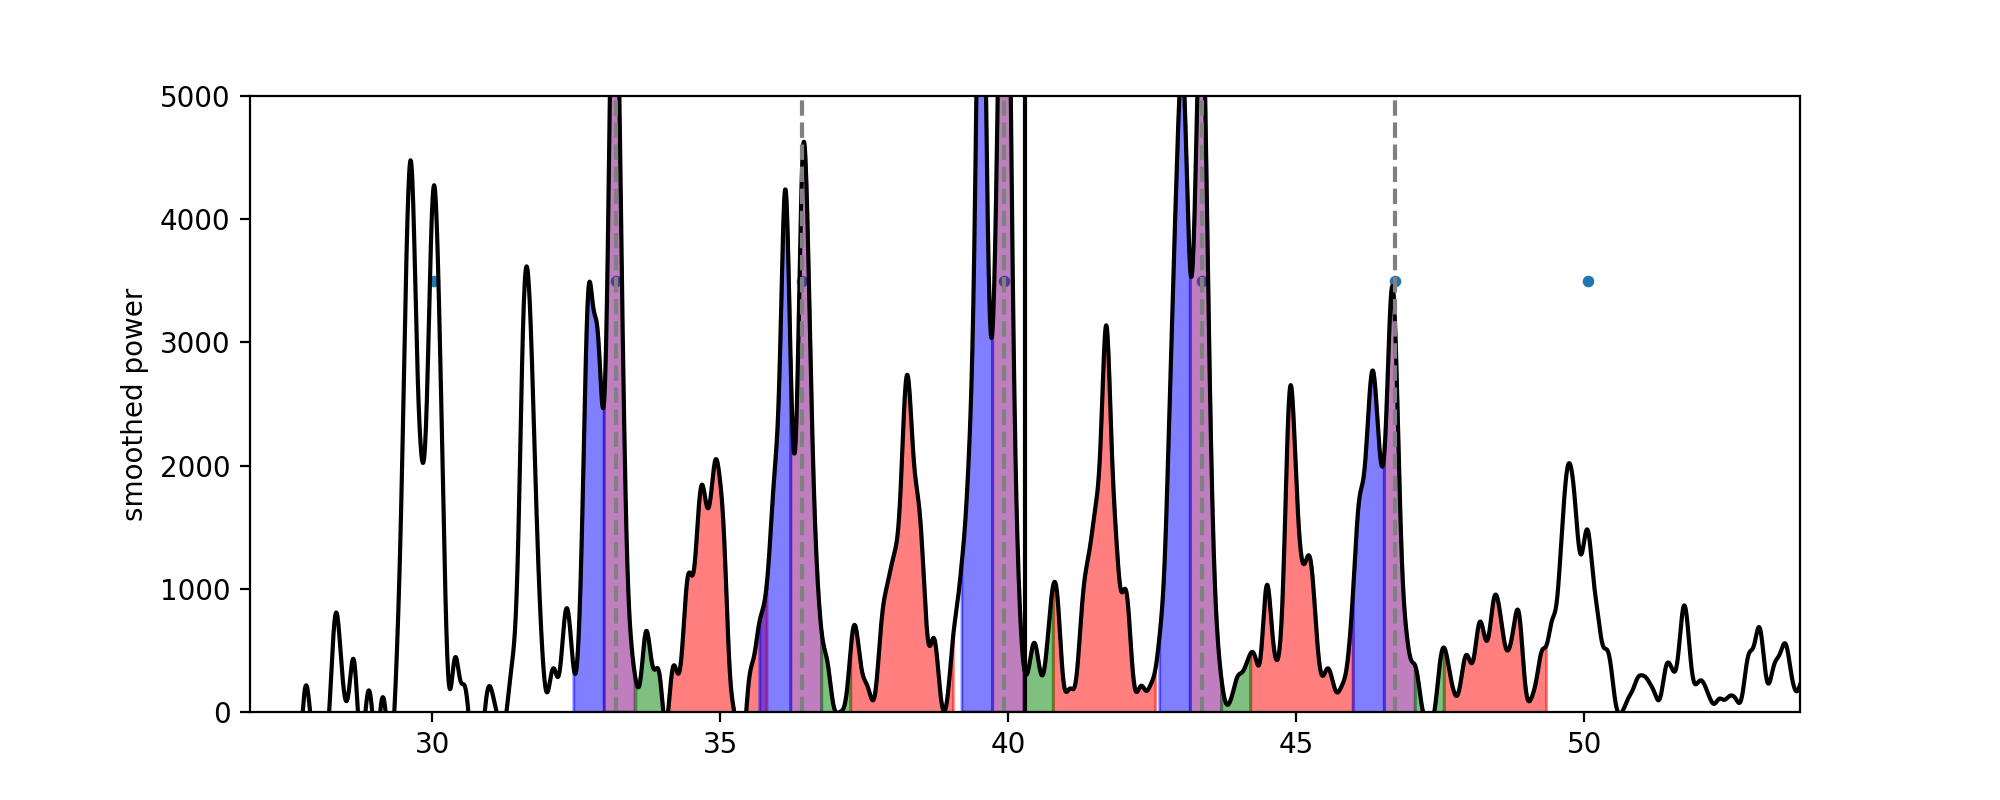

mode amplitudes
1705.9731045862982 1231.6438584340344 1015.9096419350223 152.5381375652331
1335.3948758032734 1415.2570296253368 1053.939772700013 54.83433249478329
2098.8168716407968 1471.3922690603465 1792.1683008949424 214.94479613348582
1703.0658200161683 1287.7146406595687 1553.0118487948387 89.17283618367661
909.8965675175516 751.4149689755209 957.0801363634814 71.08844389808255
mean mode amplitudes
2964.846123199005 2367.0439215962874 2442.3200584479227 222.63755356638694
Visibilites for KIC 3347458
dipole visiblity: 0.8
quadrupole visiblity: 0.82
octupole visiblity: 0.08
wrote to output dataframe


In [76]:
delta_nu,nu_max,lightcurve,powerspec = read_star_bsps('KIC '+str(kic_number),suppress_output=False)
freq_res = np.median(np.diff(powerspec['freq']))
smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))

# accounting for asymmetries Stello 2016 (PASA)
l0_halfwidth = 0.08
l2_halfwidth = 0.08
l1_halfwidth = 0.265
l3_halfwidth = 0.075
d02_spacing = 0.14
d01_spacing = 0.515
d03_spacing = 0.175

plt.figure(figsize=(10,4))
plt.plot(powerspec['freq'],smooth_power,color='k')

plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

###################

def define_regions(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu
    

    plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][octupo_region],smooth_power[octupo_region], 0, color='green',alpha=0.5)
    
for i in [-2,-1,0,1,2]:
    define_regions(i)

###################

plt.axvline(nu_max,color='k')
plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
subset = powerspec['power'][(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.1)
plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.show()

print('mode amplitudes')
def find_mode_amps(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu

    # using unsmoothed power here, that seems more right
    # I don't think I need to have the frequency resolution here??
    # need the power density!
    eff_obs_time = len(lightcurve) * 1800e-6
    l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
                                     y=powerspec['power'][radial_region]*eff_obs_time))*freq_res
    l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
                                     y=powerspec['power'][dipole_region]*eff_obs_time))*freq_res
    l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
                                     y=powerspec['power'][quadru_region]*eff_obs_time))*freq_res
    l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
                                     y=powerspec['power'][octupo_region]*eff_obs_time))*freq_res
    print(l0_amp,l1_amp,l2_amp,l3_amp)
    return l0_amp,l1_amp,l2_amp,l3_amp

l0_amp_arr = []
l1_amp_arr = []
l2_amp_arr = []
l3_amp_arr = []
for i in [-2,-1,0,1,2]:
    l0,l1,l2,l3 = find_mode_amps(i)
    l0_amp_arr.append(l0)
    l1_amp_arr.append(l1)
    l2_amp_arr.append(l2)
    l3_amp_arr.append(l3)
    
FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# FWHM = 1
# print(FWHM)
sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

def mean_calculation(index=0):
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
    quadru_mode = radial_mode - d02_spacing*delta_nu
    l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
    dipole_mode = radial_mode + d01_spacing*delta_nu
    l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
    octupo_mode = radial_mode + d03_spacing*delta_nu
    l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
    return l0_denom,l1_denom,l2_denom,l3_denom

l0_denom_arr = []
l1_denom_arr = []
l2_denom_arr = []
l3_denom_arr = []
for i in [-2,-1,0,1,2]:
    l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
    l0_denom_arr.append(l0_denom)
    l1_denom_arr.append(l1_denom)
    l2_denom_arr.append(l2_denom)
    l3_denom_arr.append(l3_denom)
# l0_denom_arr

print('mean mode amplitudes')
mean_l0_amp = np.sum(l0_amp_arr)/np.sum(l0_denom_arr)
mean_l1_amp = np.sum(l1_amp_arr)/np.sum(l1_denom_arr)
mean_l2_amp = np.sum(l2_amp_arr)/np.sum(l2_denom_arr)
mean_l3_amp = np.sum(l3_amp_arr)/np.sum(l3_denom_arr)
print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

l1_visibility = mean_l1_amp/mean_l0_amp
l2_visibility = mean_l2_amp/mean_l0_amp
l3_visibility = mean_l3_amp/mean_l0_amp
print('Visibilites for KIC',kic_number)
print('dipole visiblity:',np.round(l1_visibility,2))
print('quadrupole visiblity:',np.round(l2_visibility,2))
print('octupole visiblity:',np.round(l3_visibility,2))

print('wrote to output dataframe')
star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# type(star_ind)
highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)
highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)

In [32]:
delta_nu,nu_max,lightcurve,powerspec = read_star_bsps('KIC '+str(kic_number),suppress_output=False)

KIC 9612933
delta_nu = 4.432696858
nu_max = 52.46804315
returning dataframes


<IPython.core.display.Javascript object>


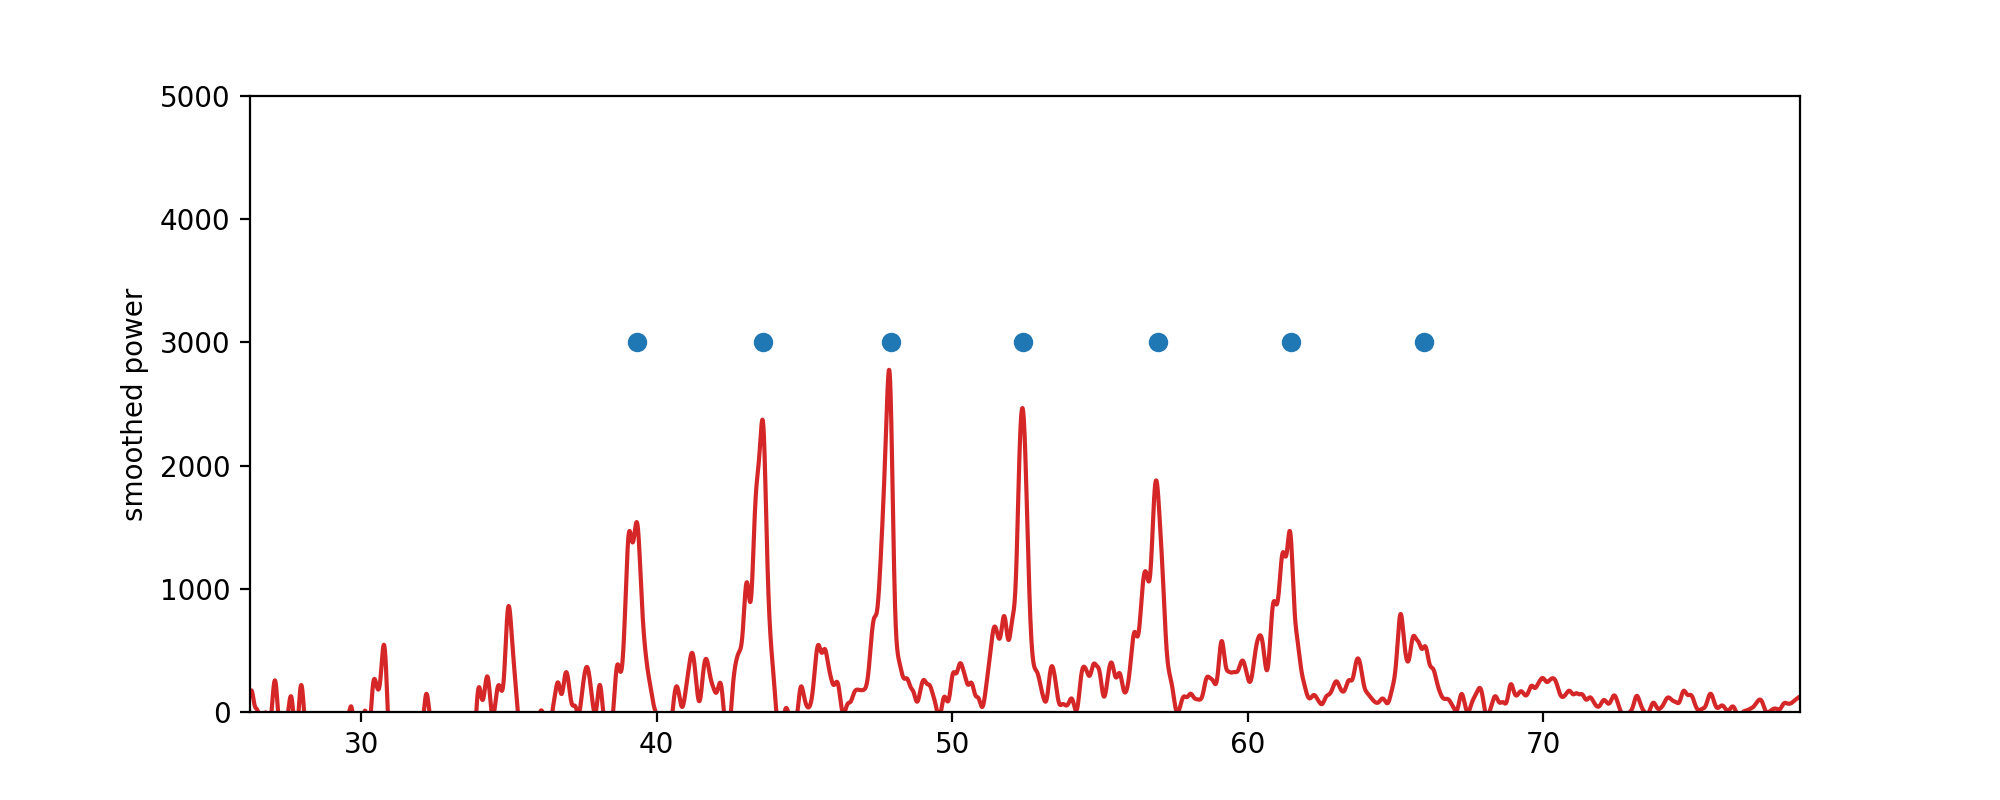

In [33]:
# radial = (7 + highmass_rc_newvals['epsilon'][highmass_rc_newvals['KIC']==3120567].values[0]*delta_nu)*delta_nu

# plt.figure(figsize=(10,4))
# plt.plot(powerspec['freq'],powerspec['power'])
freq_res = np.median(np.diff(powerspec['freq']))
smooth_power = convolve(powerspec['power'],Gaussian1DKernel(0.02*delta_nu/freq_res))
# plt.plot(powerspec['freq'],smooth_power,color='tab:red')

# peaks, _ = sp.signal.find_peaks(smooth_power,prominence=np.median(smooth_power)*250)#0.75)#prominence=10) 
# found_peaks = powerspec['freq'][peaks]
# plt.scatter(powerspec['freq'][peaks],smooth_power[peaks],marker='x',color='tab:green',s=30,zorder=3)

# plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3000))

# # plt.axvline(radial,color='k')

# plt.xlim(nu_max*0.5,nu_max*1.5)
# subset = powerspec['power'][(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
# peak = max(subset)
# plt.ylim(0,peak*1.1)
# plt.ylim(top=5000)
# plt.ylabel('smoothed power')
# plt.show()

In [34]:
# widths are 0.16Δν, 0.53Δν and 0.16Δν wide for l = 0–2, respectively
# using l=2 modes 0.12Δν to the left and l=1 modes 0.52Δν to the right

In [35]:
## all from Stello 2016 (nature)
# l0_halfwidth = 0.08
# l2_halfwidth = 0.08
# l1_halfwidth = 0.265
# d02_spacing = 0.12
# d01_spacing = 0.52

# accounting for asymmetries Stello 2016 (PASA)
l0_halfwidth = 0.08
l2_halfwidth = 0.08
l1_halfwidth = 0.265
l3_halfwidth = 0.075
d02_spacing = 0.14
d01_spacing = 0.515
d03_spacing = 0.175

<IPython.core.display.Javascript object>


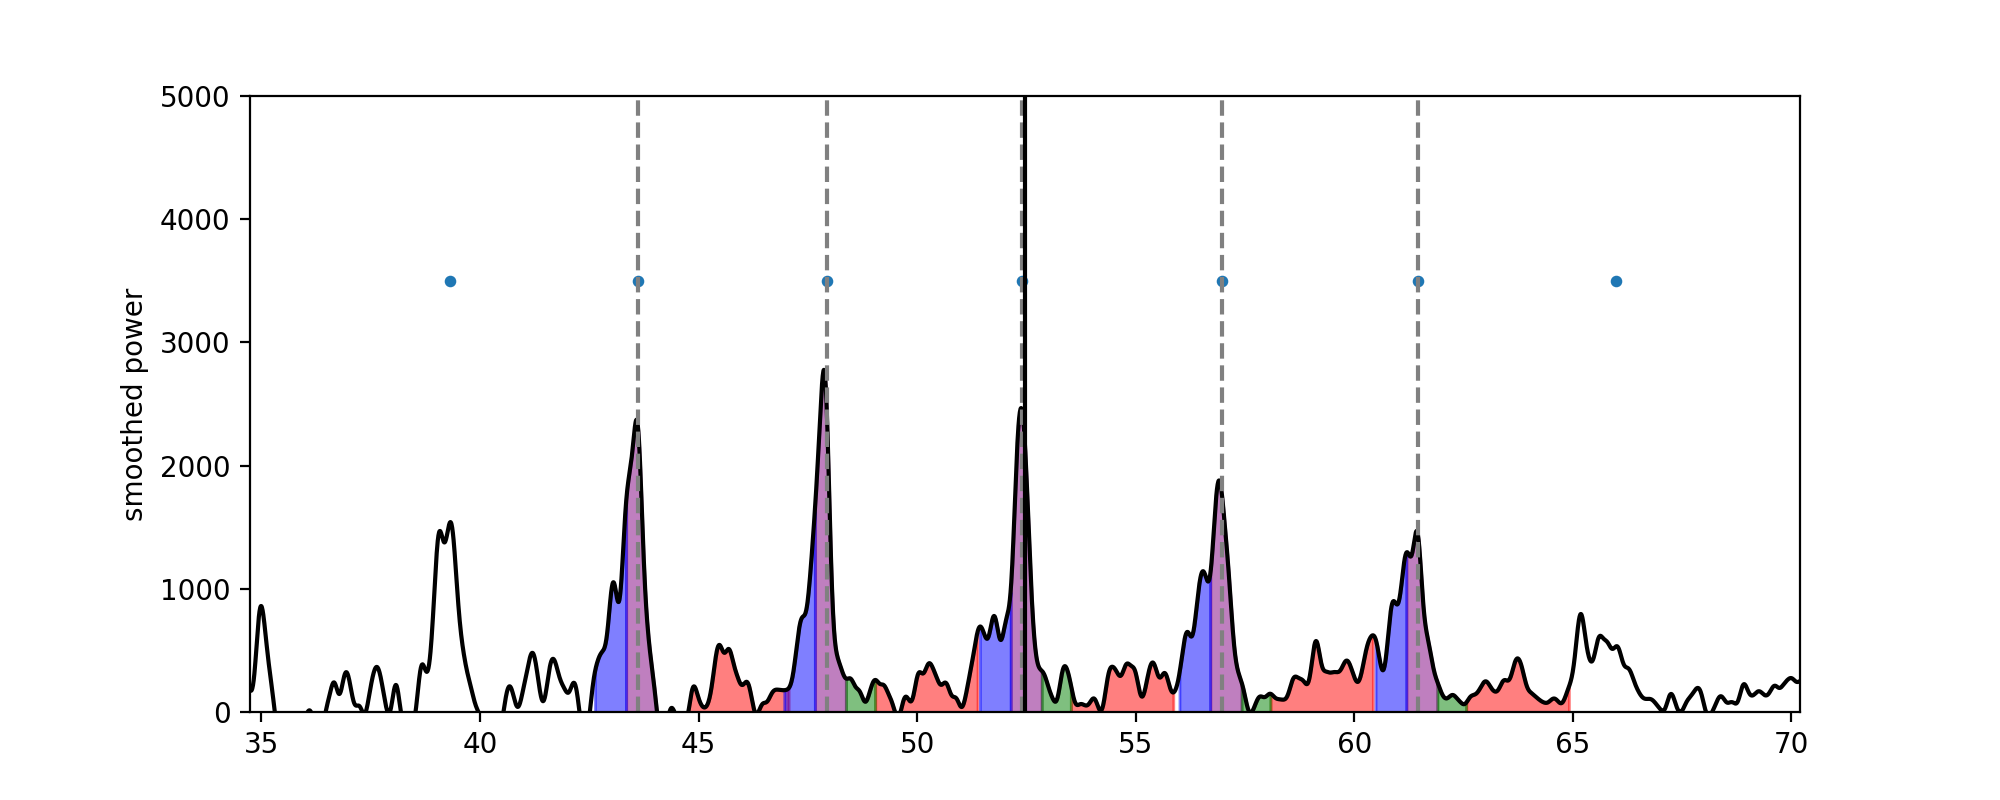

In [36]:
plt.figure(figsize=(10,4))
plt.plot(powerspec['freq'],smooth_power,color='k')

# plt.scatter(powerspec['freq'][peaks],smooth_power[peaks],marker='x',color='tab:green',s=30,zorder=3)

plt.scatter(star.f_labels[0],np.full(len(star.f_labels[0]),3500),s=10)
plt.scatter(star.f_labels[1],np.full(len(star.f_labels[1]),3500),s=10)
plt.scatter(star.f_labels[2],np.full(len(star.f_labels[2]),3500),s=10)

###################

def define_regions(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-(radial_mode+0.02*delta_nu))<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu
    

    plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][radial_region],smooth_power[radial_region], 0, color='purple',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][quadru_region],smooth_power[quadru_region], 0, color='blue',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][dipole_region],smooth_power[dipole_region], 0, color='red',alpha=0.5)
#     plt.axvline(radial_mode,color='grey',linestyle='--')
    plt.fill_between(powerspec['freq'][octupo_region],smooth_power[octupo_region], 0, color='green',alpha=0.5)
    
for i in [-2,-1,0,1,2]:
    define_regions(i)

###################

plt.axvline(nu_max,color='k')
plt.xlim(nu_max-4*delta_nu,nu_max+4*delta_nu)
subset = powerspec['power'][(nu_max*0.8 < powerspec['freq']) & (powerspec['freq'] < nu_max*1.2)]
peak = max(subset)
plt.ylim(0,peak*1.1)
plt.ylim(top=5000)
plt.ylabel('smoothed power')
plt.show()

$$A_{0}^{2}(n) = \delta \nu \int_{n-e_{20}}^{n+e_{03}}[p(n')-B]dn'$$
where p = power density, B = local background, $\delta \nu$ the frequency resolution   
where also $e_{12}$ = -0.22, $e_{20}$ = -0.065, $e_{03}$ = 0.17, $e_{31}$ = 0.27   
then   
$$\langle A_{\ell}^{2} \rangle = \sum_{n_{max}-2}^{n_{max}+2} A_{\ell}^{2}(n)/ \sum_{n_{max}-2}^{n_{max}+2} exp[\frac{-(\nu_{n,\ell}-\nu_{max})^2}{2\sigma^2}]$$
and
$$\delta\nu_{env} = 2\sqrt{2ln2}\sigma  \rightarrow  \sigma^2 = \frac{\delta\nu_{env}^2}{8ln2}$$
is the FWHM of the envelope

In [37]:
def find_mode_amps(index=0):
    # pick the radial mode closest to numax
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    radial_region = np.abs(powerspec['freq']-radial_mode)<l0_halfwidth*delta_nu
    # find the other modes based on this
    quadru_mode = radial_mode - d02_spacing*delta_nu
    quadru_region = np.abs(powerspec['freq']-quadru_mode)<l2_halfwidth*delta_nu
    dipole_mode = radial_mode + d01_spacing*delta_nu
    dipole_region = np.abs(powerspec['freq']-dipole_mode)<l1_halfwidth*delta_nu
    octupo_mode = radial_mode + d03_spacing*delta_nu
    octupo_region = np.abs(powerspec['freq']-octupo_mode)<l3_halfwidth*delta_nu

    # using unsmoothed power here, that seems more right
    # I don't think I need to have the frequency resolution here??
    # need the power density!
    eff_obs_time = len(lightcurve) * 1800e-6
    l0_amp = (sp.integrate.trapezoid(x=powerspec['freq'][radial_region],
                                     y=powerspec['power'][radial_region]*eff_obs_time))*freq_res
    l1_amp = (sp.integrate.trapezoid(x=powerspec['freq'][dipole_region],
                                     y=powerspec['power'][dipole_region]*eff_obs_time))*freq_res
    l2_amp = (sp.integrate.trapezoid(x=powerspec['freq'][quadru_region],
                                     y=powerspec['power'][quadru_region]*eff_obs_time))*freq_res
    l3_amp = (sp.integrate.trapezoid(x=powerspec['freq'][octupo_region],
                                     y=powerspec['power'][octupo_region]*eff_obs_time))*freq_res
    print(l0_amp,l1_amp,l2_amp,l3_amp)
    return l0_amp,l1_amp,l2_amp,l3_amp

l0_amp_arr = []
l1_amp_arr = []
l2_amp_arr = []
l3_amp_arr = []
for i in [-2,-1,0,1,2]:
    l0,l1,l2,l3 = find_mode_amps(i)
    l0_amp_arr.append(l0)
    l1_amp_arr.append(l1)
    l2_amp_arr.append(l2)
    l3_amp_arr.append(l3)

1054.0240847446512 435.20036134372015 506.66747566558246 -62.59672854069388
1005.7525807668435 447.071657736507 402.69143550124625 95.62412116847455
977.0941811824352 462.37427753248187 414.38842755906745 140.75376974267903
804.8784868595812 674.6092383190507 517.4111764240228 60.47701335721502
701.0236859138639 409.129280854657 486.2904519986622 66.99081850048717


In [38]:
FWHM = pysyd_results['FWHM'][pysyd_results['KIC']==kic_number].values[0]
# FWHM = 1
# print(FWHM)
sigma_var = FWHM/(2*np.sqrt(2*np.log(2)))

def mean_calculation(index=0):
    radial_mode_ind = np.argmin(np.abs(star.f_labels[0]-nu_max))
    radial_mode = star.f_labels[0][radial_mode_ind+index]
    l0_denom = np.exp(-(radial_mode-nu_max)**2/(2*sigma_var**2))
    quadru_mode = radial_mode - d02_spacing*delta_nu
    l2_denom = np.exp(-(quadru_mode-nu_max)**2/(2*sigma_var**2))
    dipole_mode = radial_mode + d01_spacing*delta_nu
    l1_denom = np.exp(-(dipole_mode-nu_max)**2/(2*sigma_var**2))
    octupo_mode = radial_mode + d03_spacing*delta_nu
    l3_denom = np.exp(-(octupo_mode-nu_max)**2/(2*sigma_var**2))
    return l0_denom,l1_denom,l2_denom,l3_denom

l0_denom_arr = []
l1_denom_arr = []
l2_denom_arr = []
l3_denom_arr = []
for i in [-2,-1,0,1,2]:
    l0_denom,l1_denom,l2_denom,l3_denom = mean_calculation(i)
    l0_denom_arr.append(l0_denom)
    l1_denom_arr.append(l1_denom)
    l2_denom_arr.append(l2_denom)
    l3_denom_arr.append(l3_denom)
# l0_denom_arr

mean_l0_amp = np.sum(l0_amp_arr)/np.sum(l0_denom_arr)
mean_l1_amp = np.sum(l1_amp_arr)/np.sum(l1_denom_arr)
mean_l2_amp = np.sum(l2_amp_arr)/np.sum(l2_denom_arr)
mean_l3_amp = np.sum(l3_amp_arr)/np.sum(l3_denom_arr)
print(mean_l0_amp,mean_l1_amp,mean_l2_amp,mean_l3_amp)

1354.4972627598436 738.064136642173 695.3682071307311 89.98117888915849


In [39]:
l1_visibility = mean_l1_amp/mean_l0_amp
l2_visibility = mean_l2_amp/mean_l0_amp
l3_visibility = mean_l3_amp/mean_l0_amp
print('Visibilites for KIC',kic_number)
print('dipole visiblity:',np.round(l1_visibility,2))
print('quadrupole visiblity:',np.round(l2_visibility,2))
print('octupole visiblity:',np.round(l3_visibility,2))
### THESE ARE CONSISTENT WITH EXPECTED VALUES ###

Visibilites for KIC 9612933
dipole visiblity: 0.54
quadrupole visiblity: 0.51
octupole visiblity: 0.07


In [68]:
star_ind = highmass_rc_newvals[highmass_rc_newvals['KIC']==kic_number].index[0]
# type(star_ind)
highmass_rc_newvals['l1_vis'][star_ind] = np.round(l1_visibility,2)
highmass_rc_newvals['l2_vis'][star_ind] = np.round(l2_visibility,2)
highmass_rc_newvals['l3_vis'][star_ind] = np.round(l3_visibility,2)

In [70]:
highmass_rc_newvals.to_csv('../datatables/highmass_rc_newvals.csv',index=False)
# highmass_rc_newvals

# Regular period echelle (with freq list)

In [350]:
def period_echelle(freq_list,numax,dnu,dPi=0):
#     nu_max   = hist.nu_max.values[0]
#     Delta_nu = hist.delta_nu.values[0]
#     Delta_P_default = hist.delta_Pg.values[0] # seconds
#     if Delta_P == 0:
#         Delta_P = Delta_P_default
#     Delta_P = 300
#     print(Delta_P)
    
#     freq = freq[freq['Re(freq)'] < 5/3*numax]
#     dipole = freq[np.logical_and(freq.l == 1, freq.n_p > 2)]
#     period = 1/(dipole['Re(freq)']*1e-6)
    period_list = 1/(np.asarray(freq_list)*1e-6)
#     print(period)
    
#     plt.scatter(dipole['Re(freq)'] % Delta_P, dipole['Re(freq)'], 
#                 marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.figure(figsize=(6,10))
    plt.scatter(period_list % dPi, freq_list, 
                marker='.', facecolor='k', edgecolor='k',linewidth=0.5)
    plt.plot(period_list % dPi, freq_list, linewidth=0.5)
    
#     colors = ('black', 'red', 'blue', 'purple')
#     for ell in np.unique(freq.l.values):
#         nus = freq[freq.l == ell]
#         plt.scatter(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], marker='.', 
#                 facecolor=colors[ell], edgecolor='k',linewidth=0.5,
#                     alpha=1, s=nus['E_p']*150, 
#                  label=str(ell))
#         plt.plot(nus['Re(freq)'] % Dnu,
#                  nus['Re(freq)'], '.', 
#                  mfc=colors[ell], mec='white', alpha=0.85,
#                  mew=1, markersize=nus['E_p'], 
#                  label=str(ell))
    
#     plt.legend(loc='lower right')
    
    plt.axvline(dPi, ls='--', c='darkgray', zorder=-99)
    plt.axhline(numax, ls='--', c='darkgray', zorder=-99)
    
#     plt.ylim([0, nu_max*5/3*1.2])
    plt.xlim([0, dPi])
    
    plt.ylabel(r'frequency $\nu/\mu\rm{Hz}$')
    plt.xlabel(r'P $\rm{mod}\; \Delta P/s$ '+str(dPi))
    plt.title('Period Echelle Diagram', size=24)
    plt.show()

<IPython.core.display.Javascript object>


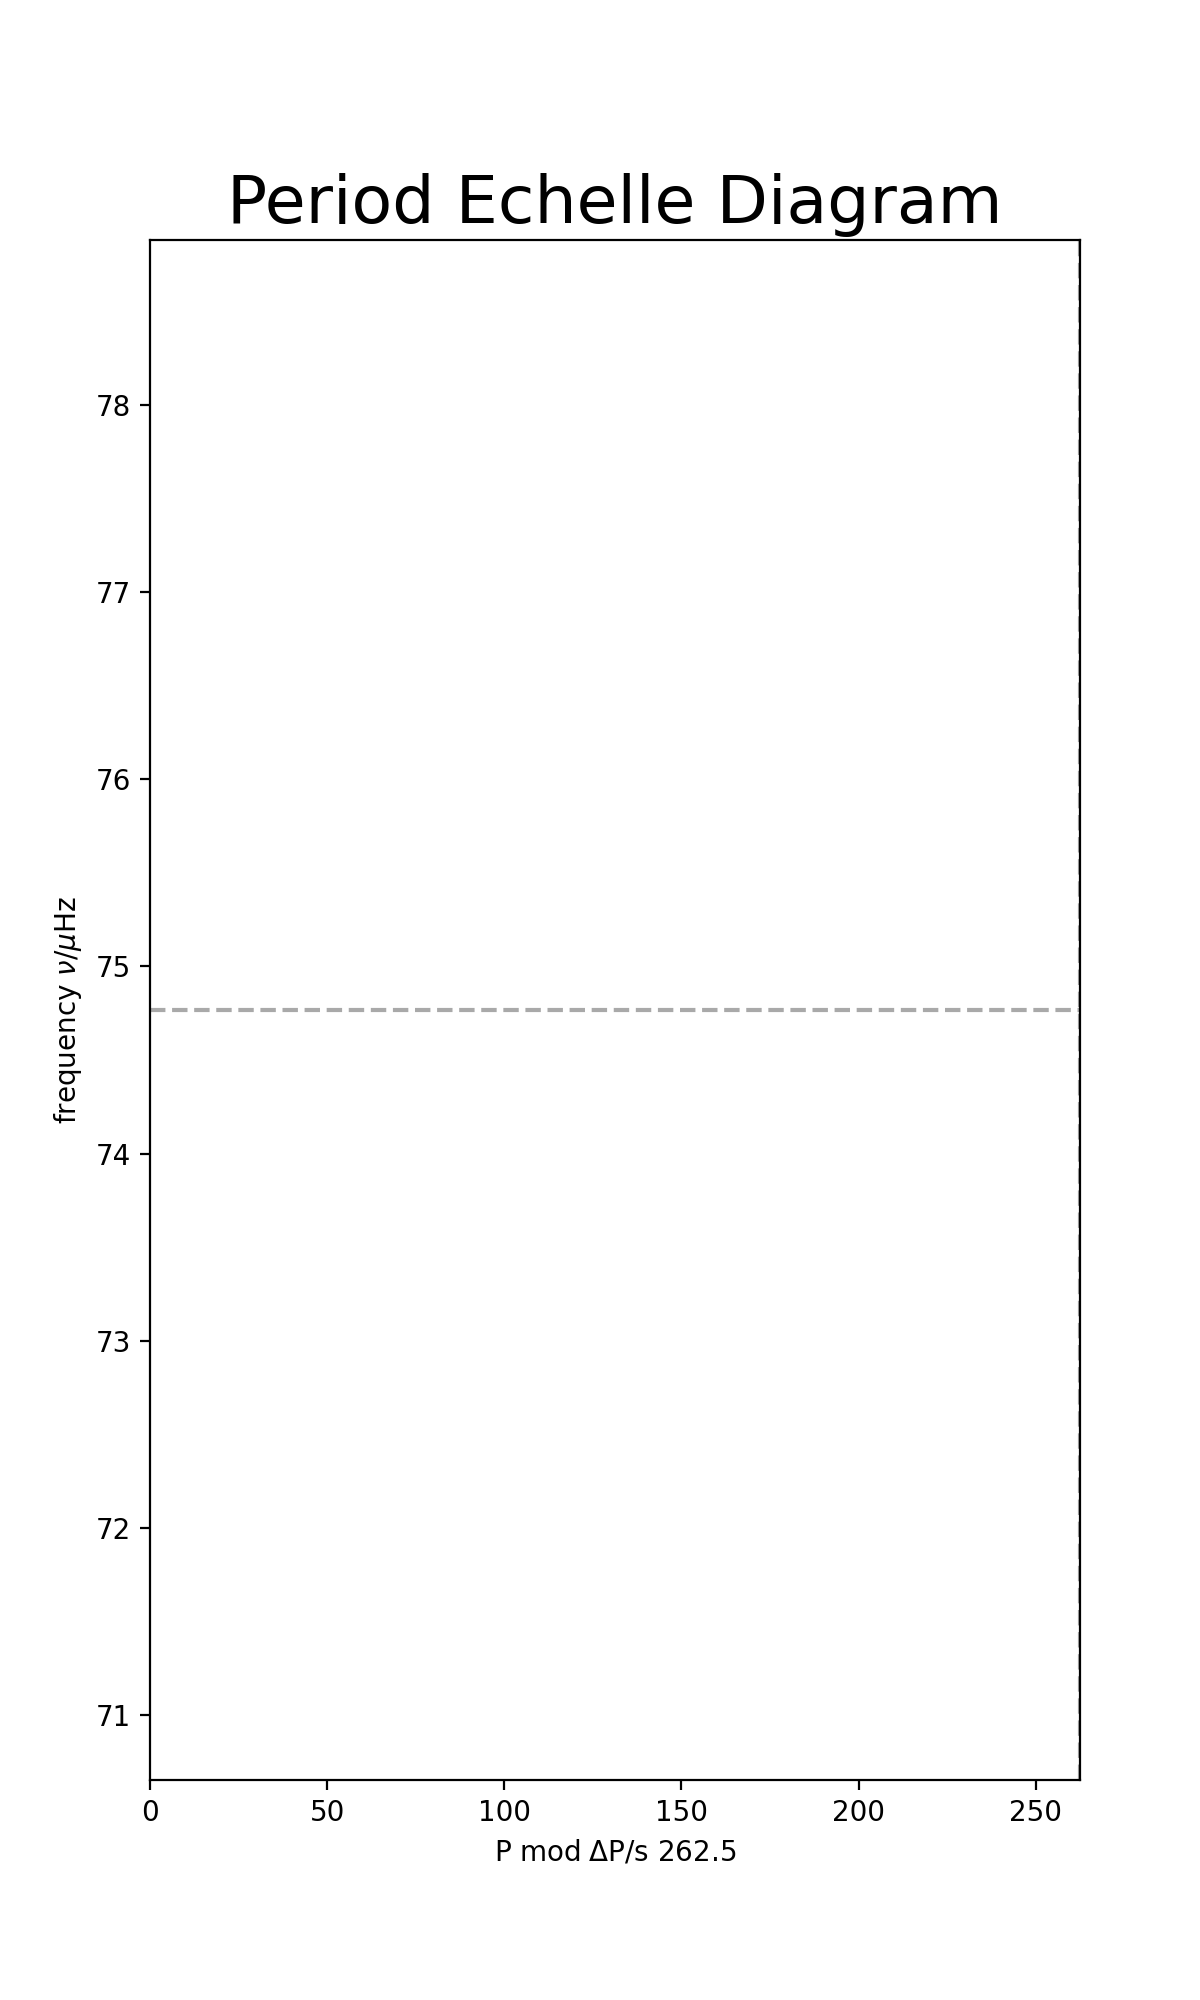

In [14]:
period_echelle(star.f_labels[1],star.numax,star.Dnu,dPi=262.5)